# Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.append('/cvmfs/icecube.opensciencegrid.org/py3-v4.3.0/RHEL_7_x86_64/lib/python3.11/site-packages/')
import photospline
from photospline import glam_fit, ndsparse, bspline

import site
sys.path.append(site.USER_SITE)
import uproot
from scipy.interpolate import interp1d
from scipy.stats import norm, kstest
from scipy.stats import ks_2samp
import healpy as hp
import glob
import time

# HAWC - Loading and reading the data

In [2]:
elements = ["proton", "helium", "carbon", "oxygen", "neon", "magnesium", "silicon", "iron"]

files = sorted(glob.glob("pass5.1/*.root"))

main_dict = {e: {} for e in elements}

for e in elements:
    data_candidates = [file for file in files if (e in file) and ('mc' not in file)]
    weight_candidates = [file for file in files if (e in file) and ('mc' in file)]

    # reading the data files
    if len(data_candidates) == 1:
        data_file = data_candidates[0]
        with uproot.open(data_file) as f:
            t = f["XCDF"]
            main_dict[e]["nChAvail"] = t["rec.nChAvail"].array(library="np")
            main_dict[e]["nHit"]      = t["rec.nHit"].array(library="np")
            main_dict[e]["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np")
            main_dict[e]["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
            main_dict[e]["zenith"]   = t["rec.zenithAngle"].array(library="np")
            main_dict[e]["coreX"]    = t["rec.coreX"].array(library="np")
            main_dict[e]["coreY"]    = t["rec.coreY"].array(library="np")
            main_dict[e]["coreR"] = np.sqrt((main_dict[e]["coreX"]-37.19)**2+(main_dict[e]["coreY"]-246)**2)/100.
            main_dict[e]["pinc"]     = t["rec.PINC"].array(library="np")
            main_dict[e]["trueEnergy"] = t["mc.logEnergy"].array(library="np")
            # t.show()

    # read the weights files
    if len(weight_candidates) ==1:
        weight_file = weight_candidates[0]
        with uproot.open(weight_file) as f:
            t = f["XCDF"]
            main_dict[e]["gsf"] = t["sweets.IWgt.gsf"].array(library="np")
            main_dict[e]["h3a"] = t["sweets.IWgt.h3a"].array(library="np")

    # defining the initial cuts
    initial_cut = np.logical_and(main_dict[e]["nHit"] > 75, main_dict[e]["zenith"] >= 0)
    initial_cut = np.logical_and(initial_cut, main_dict[e]["zenith"] < 1.222)
    initial_cut = np.logical_and(initial_cut, main_dict[e]["CxPE40XnCh"] > 40)

    # applied the initial cuts here to all the arrays
    for key in main_dict[e].keys():
        main_dict[e][key] = main_dict[e][key][initial_cut]

In [3]:
main_dict

{'proton': {'nChAvail': array([1066,  999, 1074, ..., 1063, 1070,  988], dtype=uint64),
  'nHit': array([333, 998,  86, ..., 235, 110, 976], dtype=uint64),
  'CxPE40XnCh': array([ 99, 211,  65, ..., 112,  57, 135], dtype=uint64),
  'corsikaParticleId': array([14, 14, 14, ..., 14, 14, 14], dtype=uint64),
  'zenith': array([0.1919, 0.2421, 0.0982, ..., 0.727 , 0.8772, 0.0877]),
  'coreX': array([73.4, 29.9, 97.5, ..., 94. , 35.6, 99.1]),
  'coreY': array([176.3, 246.7, 276.2, ..., 255. , 179.8, 262.6]),
  'coreR': array([0.78544599, 0.07323531, 0.67448766, ..., 0.57518485, 0.66219092,
         0.64096865]),
  'pinc': array([3.09, 2.43, 1.46, ..., 1.74, 0.81, 2.37]),
  'trueEnergy': array([3.592, 5.111, 2.494, ..., 3.657, 3.863, 5.075]),
  'gsf': array([1.03459167e-03, 6.58024165e-05, 8.19134620e-04, ...,
         9.65951095e-05, 1.05589482e-03, 1.33738021e-05]),
  'h3a': array([1.05252091e-03, 6.69624836e-05, 8.06668809e-04, ...,
         9.69478026e-05, 1.02743641e-03, 1.36929351e-05])}

In [4]:
# zenith, nHit, nChAvail, coreR, true energy, corsikaParticleID, pinc, gsf, h3a

zenith, nHit, nChAvail, coreR, log_true_E, particleId, pinc, gsf, h3a = [], [], [], [], [], [], [], [], []

for e in main_dict.keys():
    zenith.append(main_dict[e]["zenith"])
    nHit.append(main_dict[e]["nHit"])
    nChAvail.append(main_dict[e]["nChAvail"])
    coreR.append(main_dict[e]["coreR"])
    log_true_E.append(main_dict[e]["trueEnergy"])
    particleId.append(main_dict[e]["corsikaParticleId"])
    pinc.append(main_dict[e]["pinc"])
    gsf.append(main_dict[e]["gsf"])
    h3a.append(main_dict[e]["h3a"])

zenith = np.concatenate(zenith)
nHit = np.concatenate(nHit)
nChAvail = np.concatenate(nChAvail)
coreR = np.concatenate(coreR)
log_true_E = np.concatenate(log_true_E)
particleId = np.concatenate(particleId)
pinc = np.concatenate(pinc)
gsf = np.concatenate(gsf)
h3a = np.concatenate(h3a)

# HAWC - Calculate the reco energy

In [5]:
def get_reco_energy(zenith, nHit, nChAvail, coreR):
    tab1 = photospline.SplineTable(f'pass5_spline_combined3d.fits')
    x = np.cos(zenith)
    y = nHit/nChAvail
    z = coreR

    reco_energy = []

    for i in range(x.size):
        coord3d = [x[i], y[i], z[i]]
        try:
            centers = tab1.search_centers(coord3d)
            reco_energy.append(tab1.evaluate(coord3d, centers))
        except:
            reco_energy.append(-1)

    reco_energy = np.array(reco_energy)

    return reco_energy

In [6]:
reco_energy = get_reco_energy(zenith, nHit, nChAvail, coreR)

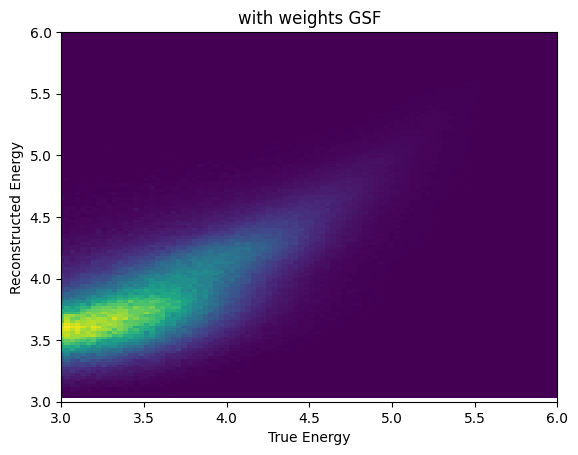

In [7]:
# visualize the reco energy and true energy relation
plt.hist2d(log_true_E, reco_energy, bins = 150, weights = gsf)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights GSF')
plt.show()

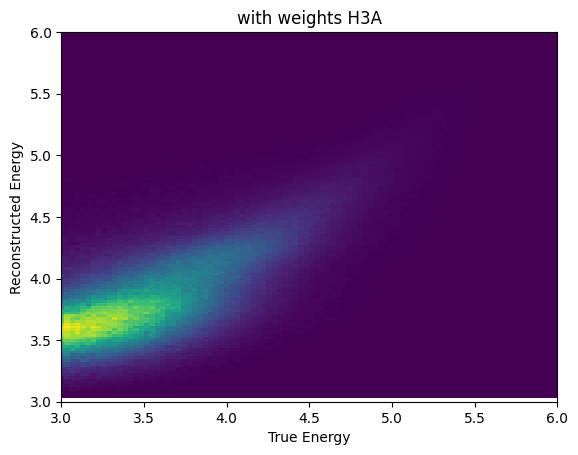

In [8]:
# visualize the reco energy and true energy relation
plt.hist2d(log_true_E, reco_energy, bins = 150, weights = h3a)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights H3A')
plt.show()

# HAWC - Converting particle IDs to atomic numbers

In [9]:
particle_ids = {14: 1, 402 : 2, 1206 : 6, 2412: 12, 2010 : 10, 1608: 8, 2814: 14, 5626: 26}

In [10]:
atomic_number = []
for i in particleId:
    atomic_number.append(particle_ids[i])

atomic_number = np.array(atomic_number)
log_atomic_number = np.log10(atomic_number)

In [11]:
true_E = np.power(10, log_true_E)
rigidity = true_E/atomic_number

In [12]:
log_rigidity = log_true_E - log_atomic_number

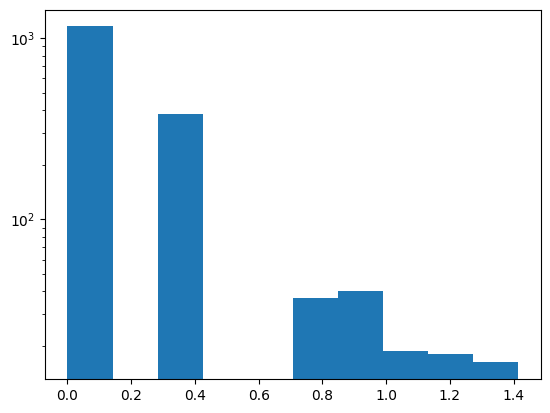

In [13]:
plt.hist(np.log10(atomic_number), weights = gsf)
plt.yscale('log')
plt.show()

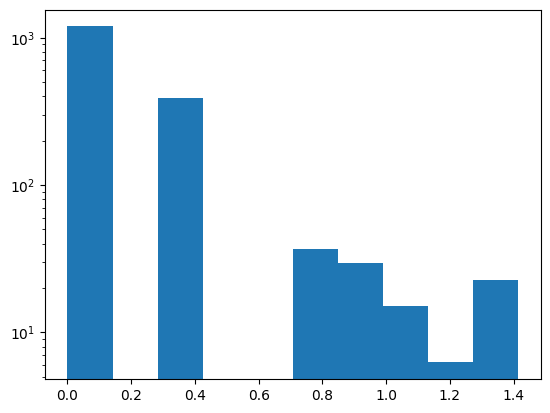

In [14]:
plt.hist(np.log10(atomic_number), weights = h3a)
plt.yscale('log')
plt.show()

# HAWC - Energy cuts on reco energy applied to true energy

- 12 total cuts going from bin0 to bin11

In [15]:
min_energies = [3.0, 3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.88, 5.15, 5.44, 5.68, 6.0]
max_energies = [3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.98, 5.15, 5.44, 5.68, 6.0, 6.9]
pinc_vals = [1.3, 1.4, 1.5, 1.4, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]

In [16]:
def cut_energy(min_energy, max_energy, pinc_val):
    cut = np.logical_and(min_energy <= reco_energy, max_energy > reco_energy)
    cut = np.logical_and(cut, pinc > pinc_val)

    return cut

In [17]:
cuts = []

for i , j , k in zip(min_energies, max_energies, pinc_vals):
    cut = cut_energy(i, j , k)
    cuts.append(cut)

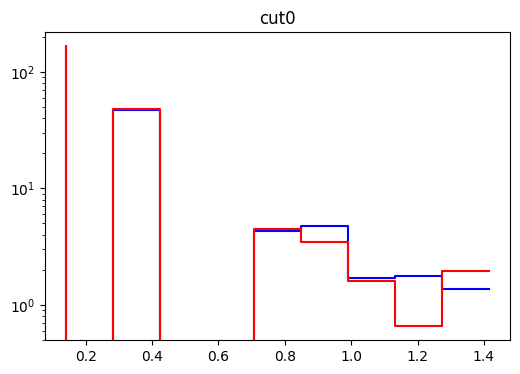

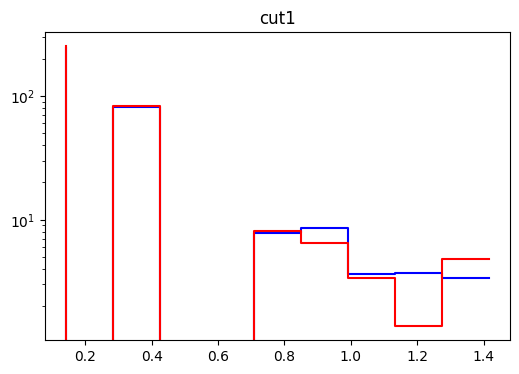

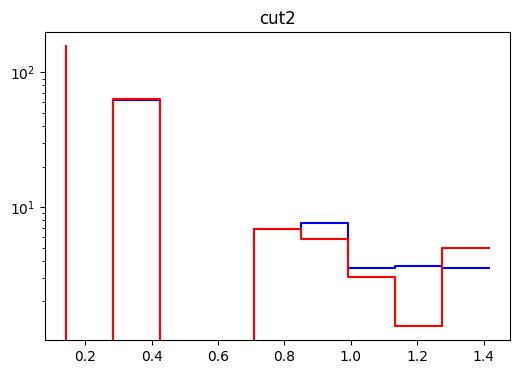

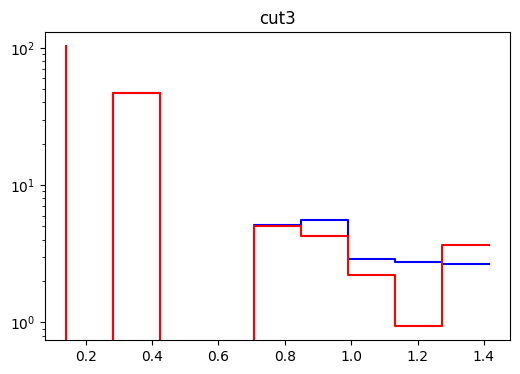

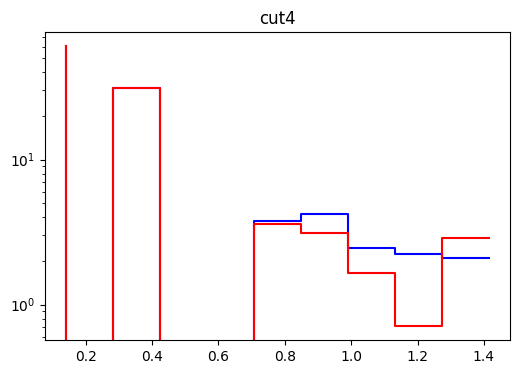

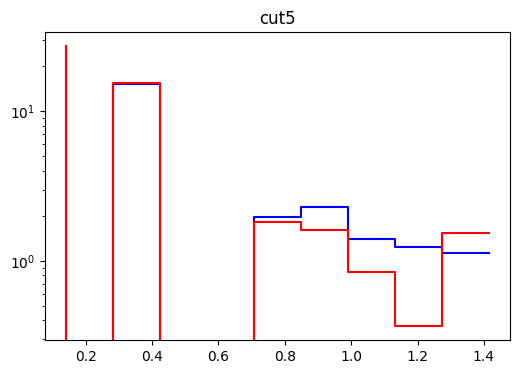

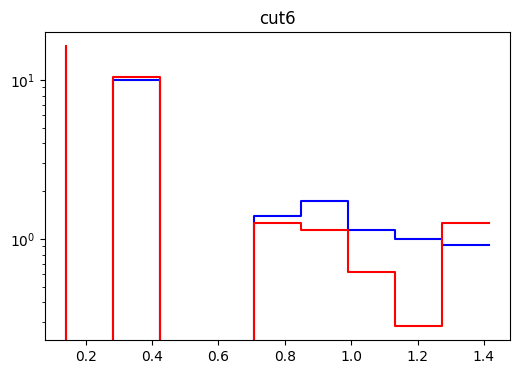

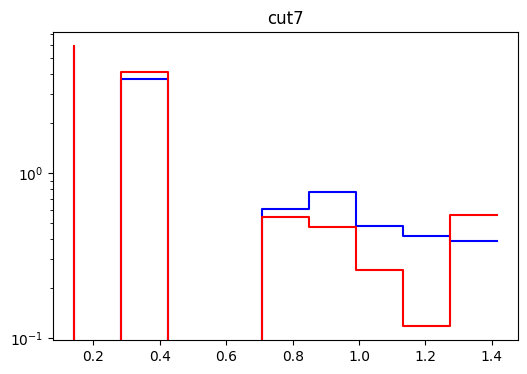

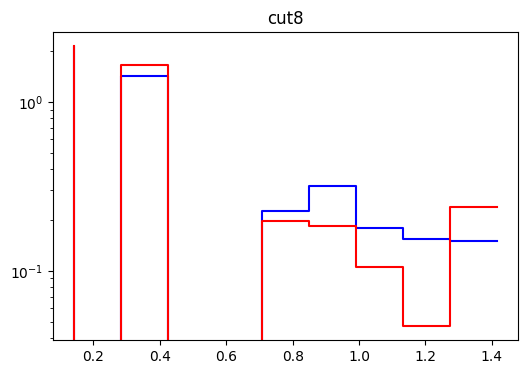

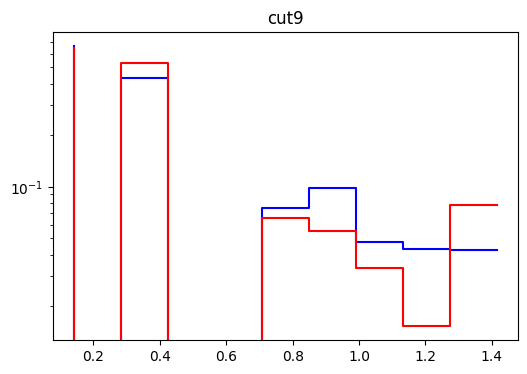

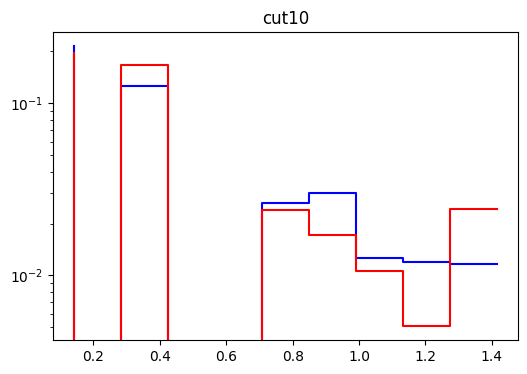

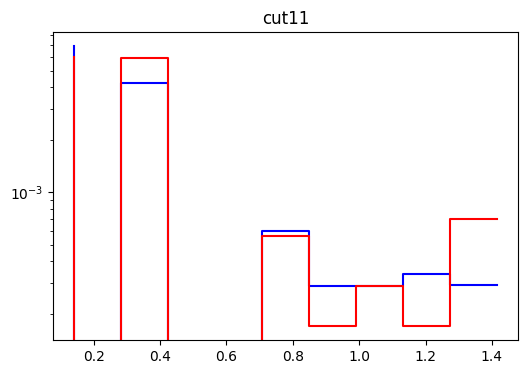

In [18]:
log_mean_e_gsf = []
log_mean_e_h3a = []
log_mean_a_gsf = []
log_mean_a_h3a = []
mean_rig_gsf = []
mean_rig_h3a = []

for i, cut in enumerate(cuts):
    # mean of the log(E)
    log_mean_energy_gsf = np.log10(np.average(true_E[cut], weights = gsf[cut]))
    log_mean_energy_h3a = np.log10(np.average(true_E[cut], weights = h3a[cut]))
    # mean of the log(Z)
    log_meanz_gsf = np.log10(np.average(atomic_number[cut], weights = gsf[cut]))
    log_meanz_h3a = np.log10(np.average(atomic_number[cut], weights = h3a[cut]))
    # mean of rigidity
    mean_rigidity_gsf = np.average(rigidity[cut], weights = gsf[cut])
    mean_rigidity_h3a = np.average(rigidity[cut], weights = h3a[cut])

    log_mean_e_gsf.append(log_mean_energy_gsf)
    log_mean_e_h3a.append(log_mean_energy_h3a)
    log_mean_a_gsf.append(log_meanz_gsf)
    log_mean_a_h3a.append(log_meanz_h3a)
    mean_rig_gsf.append(mean_rigidity_gsf)
    mean_rig_h3a.append(mean_rigidity_h3a)

    bin_gsf, edge_gsf = np.histogram(log_atomic_number[cut], weights = gsf[cut])
    bin_h3a, edge_h3a = np.histogram(log_atomic_number[cut], weights = h3a[cut])
    plt.figure(figsize = (6, 4))
    plt.step(edge_gsf[1:], bin_gsf, 'b')
    plt.step(edge_h3a[1:], bin_h3a, 'r')
    plt.yscale('log')
    plt.title(f"cut{i}")
    plt.show()

log_mean_e_gsf = np.array(log_mean_e_gsf)
log_mean_e_h3a = np.array(log_mean_e_h3a)
log_mean_a_gsf = np.array(log_mean_a_gsf)
log_mean_a_h3a = np.array(log_mean_a_h3a)
mean_rig_gsf = np.array(mean_rig_gsf)
mean_rig_h3a = np.array(mean_rig_h3a)

In [19]:
total_n_gsf, total_edges_gsf = np.histogram(log_true_E, bins = log_mean_e_gsf, weights = gsf)
total_n_h3a, total_edges_h3a = np.histogram(log_true_E, bins = log_mean_e_h3a, weights = h3a)

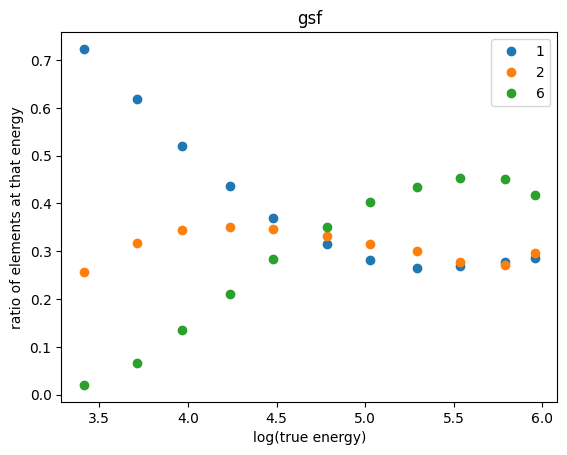

In [20]:
# for i in np.unique(atomic_number):
# gsf
for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(log_true_E[atomic_number >= i], bins = log_mean_e_gsf, weights = gsf[atomic_number >= i])
    else:
        ni, ei = np.histogram(log_true_E[atomic_number == i], bins = log_mean_e_gsf, weights = gsf[atomic_number == i])

    frac = ni/total_n_gsf
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.title("gsf")
plt.xlabel("log(true energy)")
plt.ylabel("ratio of elements at that energy")
plt.legend()
plt.show()

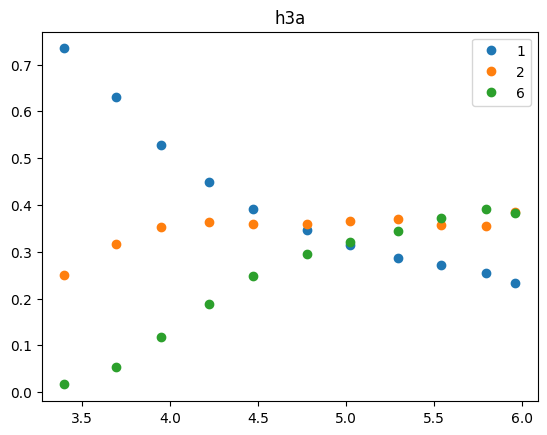

In [21]:
# h3a
for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(log_true_E[atomic_number >= i], bins = log_mean_e_h3a, weights = h3a[atomic_number >= i])
    else:
        ni, ei = np.histogram(log_true_E[atomic_number == i], bins = log_mean_e_h3a, weights = h3a[atomic_number == i])

    frac = ni/total_n_h3a
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.title("h3a")
plt.legend()
plt.show()

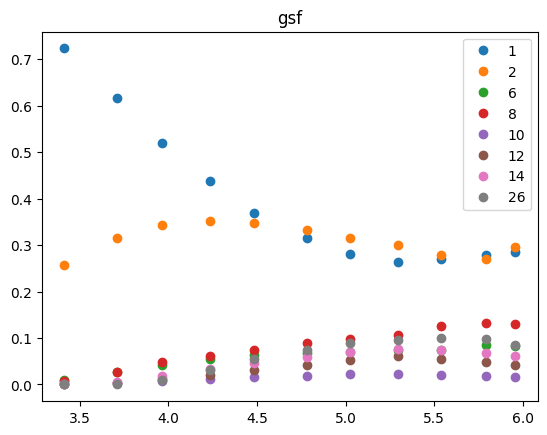

In [22]:
# gsf
for i in np.unique(atomic_number):
    ni, ei = np.histogram(log_true_E[atomic_number == i], bins = log_mean_e_gsf, weights = gsf[atomic_number == i])

    frac = ni/ total_n_gsf
    plt.plot(ei[1:], frac, 'o', label = str(i))

plt.title("gsf")
plt.legend()
plt.show()

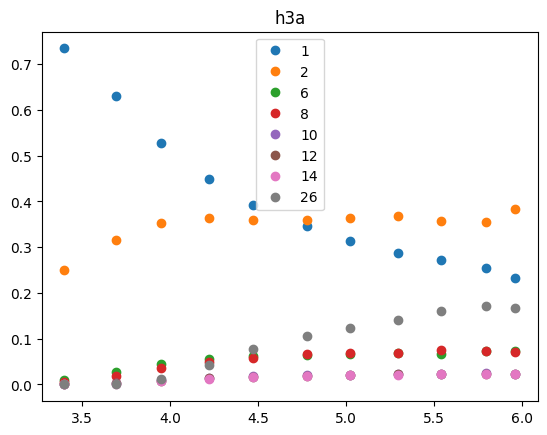

In [23]:
# h3a
for i in np.unique(atomic_number):
    ni, ei = np.histogram(log_true_E[atomic_number == i], bins = log_mean_e_h3a, weights = h3a[atomic_number == i])

    frac = ni/ total_n_h3a
    plt.plot(ei[1:], frac, 'o', label = str(i))

plt.title("h3a")
plt.legend()
plt.show()

In [24]:
# the below approach is correct

In [25]:
mean_rig_gsf

array([   935.90484245,   1574.31263047,   2960.4999314 ,   5316.35586927,
         9564.27260779,  16410.59914412,  32030.53406126,  56296.08548512,
       107770.71539087, 195894.83836129, 367059.00581334, 596513.8669977 ])

In [26]:
log_mean_rig_gsf = np.log10(mean_rig_gsf)
log_mean_rig_gsf

array([2.97123169, 3.19709098, 3.47136506, 3.72561404, 3.98065195,
       4.21512444, 4.50556418, 4.7504782 , 5.03250077, 5.29202299,
       5.56473588, 5.77562054])

In [27]:
log_mean_rig_h3a = np.log10(mean_rig_h3a)
log_mean_rig_h3a

array([2.97988838, 3.19678377, 3.46735754, 3.72484226, 3.98809252,
       4.23020501, 4.52620937, 4.76926684, 5.04231949, 5.28804735,
       5.54862396, 5.74158894])

# IceCube - Reading and viewing the files

- nchannel: number of active channels
- llhZen: reconstructed zenith
- llhAz: reconstructed azimuth
- zenith: zenith angle
- azimuth: azimuth angle
- mc_energy: true energy
- type: proton, helium, nitrogen, aluminium, iron
- energy: true energy
- GaisserH3a: weights
- Hoerandel: weights
- GlobalFitGST: weights
- reco_energy: reconstructed energy

In [28]:
dst = np.load('dst_20904_v2.npz')

print(dst.files)

# accessing individual numpy arrays from the file
# dst['zenith']

['nchannel', 'llhZen', 'llhAz', 'zenith', 'azimuth', 'mc_energy', 'type', 'isgoodllh', 'ndir', 'ldir', 'rlogl', 'atmosphere', 'TriggID_1006', 'energy', 'GaisserH3a', 'Hoerandel', 'GlobalFitGST', 'GlobalSplineFit5Comp', 'reco_energy']


[4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5]

bin edges in log for the reco energy

# IceCube - Applying initial cuts

In [29]:
imain_cut = np.logical_and(dst['nchannel'] > 10, dst['llhZen'] < 70)

ienergy = dst['energy'][imain_cut]
log_ienergy = np.log10(dst['energy'][imain_cut])
weights_h3a = dst['GaisserH3a'][imain_cut]
# weights_2 = dst['Hoerandel'][imain_cut]
weights_gsf = dst['GlobalSplineFit5Comp'][imain_cut]
ireco_energy = dst['reco_energy'][imain_cut]
inchannel = dst['nchannel'][imain_cut]
ireco_zenith = dst['llhZen'][imain_cut]
izenith = dst['zenith'][imain_cut]
itype = dst['type'][imain_cut]

iparticle_ids = {2212: 1, 1000020040: 2, 1000070140: 7, 1000130270: 13, 1000260560: 26}

In [30]:
# get the atomic number from the particle ids for each particle
iatomic = []
for i in itype:
    iatomic.append(iparticle_ids[i])

iatomic = np.array(iatomic)
log_iatomic = np.log10(iatomic)

Rigidity equation: \
R = E / Z

In [31]:
# get the rigidity for each event
# this is a numpy array
irigidity = ienergy / iatomic

# Approach
- argsort on reco energy
- apply it on all the other arrays
- define the cdf and weighted ks test functions
- use the vectorized approach and traverse the reco energy array to get windows
- for each window, find the cdf of both hawc and icecube and then perform the weighted ks test
- store the distance somewhere associated to that window
- find the minimum difference and identify that window
- that will be the most compatible to hawc
- do this for all the hawc bins
- store the emin and emax for later use

## Argsorting the array

In [32]:
# argsort on reco_energy and apply it to all the other arrays
order = np.argsort(ireco_energy)
# true energy
ienergy = ienergy[order]
# log true energy
log_ienergy = log_ienergy[order]
# atomic number
iatomic = iatomic[order]
# log of atomic number
log_iatomic = log_iatomic[order]
# gsf weights
weights_gsf = weights_gsf[order]
# h3a weights
weights_h3a = weights_h3a[order]
# reconstructed energy
ireco_energy = ireco_energy[order]
# rigidity
irigidity = irigidity[order]

## Weighted cumulative distribution function

In [33]:
# empirical cumulative distribution function - here empirical stands for real world observations
# returns x_sorted - sorted values, cdf - the cumulative distribution (from 0 to 1)
def weighted_ecdf(energy, weights):
    
    # Sort by the values
    order = np.argsort(energy)
    x_sorted = energy[order]
    w_sorted = weights[order]

    # Weighted cumulative sum
    cum_w = np.cumsum(w_sorted)
    total_w = cum_w[-1] # last value of the weights will be the total sum of all the weights

    # normalizing the cdf
    cdf = cum_w / total_w
    return x_sorted, cdf

## Plotting the weighted ecdf function

In [34]:
# weighted ecdf by seaborn along with a plot.
def plot_ecdf(x_sorted, cdf):
    plt.figure(figsize=(6,4))
    plt.plot(x_sorted, cdf, 'bo')
    plt.xlabel('energy')
    plt.ylabel('cdf of weights')
    plt.show()

## Weighted KS test function
- this won't return a p-value and the p-value is not useful anyways because HAWC and IceCube have very different cdfs

In [35]:
def weighted_ks_2samp(hawc_data, hawc_weights, icecube_data, icecube_weights):
    """
    Weighted two-sample Kolmogorov-Smirnov test (no p-value).
    Returns:
        ks_stat : the maximum distance between the two weighted CDFs
    """
    # this will return a normalized ecdf
    x1_sorted, cdf1 = weighted_ecdf(hawc_data, hawc_weights)
    x2_sorted, cdf2 = weighted_ecdf(icecube_data, icecube_weights)

    # initializing the counters
    i1 = 0
    i2 = 0
    d_max = 0.0
    n1 = len(x1_sorted)
    n2 = len(x2_sorted)

    # initializing cdf values
    c1 = 0.0
    c2 = 0.0

    # are we iterating through all the values of the energy data????
    # this while loop is a very time consuming step
    # make this better
    while i1 < n1 and i2 < n2:
        v1 = x1_sorted[i1]
        v2 = x2_sorted[i2]
        if v1 < v2:
            c1 = cdf1[i1]
            i1 += 1
        elif v2 < v1:
            c2 = cdf2[i2]
            i2 += 1
        else:
            c1 = cdf1[i1]
            c2 = cdf2[i2]
            i1 += 1
            i2 += 1
        d = abs(c1 - c2)
        if d > d_max:
            d_max = d

    # If one array is exhausted, continue stepping through the other
    # need to make this a conditional thing instead of two more while loops
    # three while loops will take a lot of time
    while i1 < n1:
        # dont need this again
        c1 = cdf1[i1]
        i1 += 1
        d = abs(c1 - c2)
        if d > d_max:
            d_max = d

    while i2 < n2:
        # same here
        c2 = cdf2[i2]
        i2 += 1
        d = abs(c1 - c2)
        if d > d_max:
            d_max = d

    return d_max  # no p-value for the weighted case

## Optimized weighted ks test function

In [36]:
def weighted_ks_2samp_optimized(x1_sorted, cdf1, x2_sorted, cdf2):
    i1, i2 = 0, 0
    d_max = 0.0
    c1, c2 = 0.0, 0.0
    n1, n2 = len(x1_sorted), len(x2_sorted)

    while i1 < n1 or i2 < n2:
        
        if i2 >= n2 or (i1 < n1 and x1_sorted[i1] < x2_sorted[i2]):
            c1 = cdf1[i1]
            i1 += 1
            
        elif i1 >= n1 or x2_sorted[i2] < x1_sorted[i1]:
            c2 = cdf2[i2]
            i2 += 1
            
        else:
            c1 = cdf1[i1]
            c2 = cdf2[i2]
            i1 += 1
            i2 += 1

        d = abs(c1 - c2)
        if d > d_max:
            d_max = d

    return d_max

## Vectorized KS test function
- this one is using interpolation (np.interp)

In [37]:
def weighted_ks_2samp_vectorized(x1, w1, x2, w2):
    
    x1_sorted, cdf1 = weighted_ecdf(x1, w1)
    x2_sorted, cdf2 = weighted_ecdf(x2, w2)
    # For each point in x1_sorted, interpolate the CDF of sample 2.
    interp_cdf2 = np.interp(x1_sorted, x2_sorted, cdf2, left=0, right=1)
    d1 = np.max(np.abs(cdf1 - interp_cdf2))
    # Repeat in reverse: for each point in x2_sorted, interpolate the CDF of sample 1.
    interp_cdf1 = np.interp(x2_sorted, x1_sorted, cdf1, left=0, right=1)
    d2 = np.max(np.abs(cdf2 - interp_cdf1))
    
    return max(d1, d2)

## Final KS test function

In [38]:
def ks_w2(data1, data2, wei1, wei2):

    # Sort each data set
    idx1 = np.argsort(data1)
    idx2 = np.argsort(data2)
    d1_sorted = data1[idx1]
    w1_sorted = wei1[idx1]
    d2_sorted = data2[idx2]
    w2_sorted = wei2[idx2]

    cwei1 = np.concatenate((
        [0],
        np.cumsum(w1_sorted) / w1_sorted.sum()
    ))
    cwei2 = np.concatenate((
        [0],
        np.cumsum(w2_sorted) / w2_sorted.sum()
    ))

    merged = np.concatenate((d1_sorted, d2_sorted))
    merged_sorted = np.unique(np.sort(merged))

    cdf1_idx = np.searchsorted(d1_sorted, merged_sorted, side='right')
    cdf2_idx = np.searchsorted(d2_sorted, merged_sorted, side='right')
    cdf1we = cwei1[cdf1_idx]
    cdf2we = cwei2[cdf2_idx]

    return np.max(np.abs(cdf1we - cdf2we))

## Weighted quantile function

In [39]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ 
    Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!

    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.

    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

## Sliding Window approach

### test for the data - dont run this

In [ ]:
# time taken for one hawc cut with 100 windows = 5 seconds
# time taken for one hawc cut with 1000 windows = 51 seconds
# time taken for one hawc cut with 10,000 windows = 502 seconds
# so we use 1000 windows, takes moderate time and gives very accurate results

In [54]:
# lets test out the new appraoch with just 100 values of emin to see what the ks value looks like for each emin, emax range
# this basically means that we have 100 windows
windows = 100
emin_range = np.linspace(3.0, 8.0, windows)

In [55]:
window_width = 0.25

hawc_rigidity = rigidity[cuts[10]]
hawc_weights = gsf[cuts[1]]

ks_values = np.full(windows, np.nan)

start = time.time()
for i, emin in enumerate(emin_range):
    emax = emin + window_width
    icut = np.logical_and(ireco_energy >= emin, ireco_energy < emax)
    irigidity_cut = irigidity[icut]
    weights_cut = weights_gsf[icut]
    ks_val = ks_w2(hawc_rigidity, irigidity_cut, hawc_weights, weights_cut)
    ks_values[i] = ks_val

end = time.time()
print(f"time taken is {end - start} seconds")

time taken is 2.857391119003296 seconds


In [56]:
np.log10(mean_rig_gsf[10])

5.564735883977709

In [57]:
# 100 windows
best_ks_idx = np.nanargmin(ks_values)
print(f"Best ks value: {ks_values[best_ks_idx]} and emin for that in reco energy is {emin_range[best_ks_idx]}")
print(f"energy range: {emin_range[best_ks_idx]}, {emin_range[best_ks_idx] + 0.25}")

Best ks value: 0.08218805782548266 and emin for that in reco energy is 5.828282828282829
energy range: 5.828282828282829, 6.078282828282829


In [58]:
this_cut = np.logical_and(ireco_energy >= 5.82828, ireco_energy < 6.07828)
this_avg_rig = np.average(irigidity[this_cut], weights = weights_gsf[this_cut])
np.log10(this_avg_rig)

5.881499875279626

In [94]:
# 1000 windows
best_ks_idx = np.nanargmin(ks_values)
print(f"Best ks value: {ks_values[best_ks_idx]} and emin for that in reco energy is {emin_range[best_ks_idx]}")

Best ks value: 0.061716190315722286 and emin for that in reco energy is 4.031031031031031


In [91]:
# 10,000 windows
best_ks_idx = np.nanargmin(ks_values)
print(f"Best ks value: {ks_values[best_ks_idx]} and emin for that in reco energy is {emin_range[best_ks_idx]}")

Best ks value: 0.06140380886919605 and emin for that in reco energy is 4.03010301030103


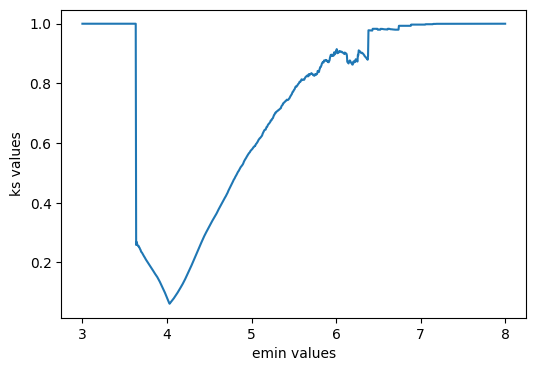

In [83]:
plt.figure(figsize = (6,4))
plt.plot(emin_range, ks_values)
plt.xlabel('emin values')
plt.ylabel('ks values')
plt.show()

### test ends

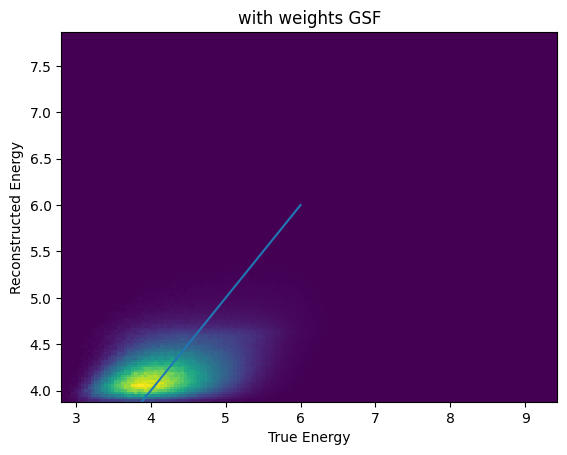

In [40]:
plt.hist2d(np.log10(ienergy), ireco_energy, bins = 150, weights = weights_gsf)
plt.plot(np.linspace(3,6), np.linspace(3,6))
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights GSF')
plt.show()

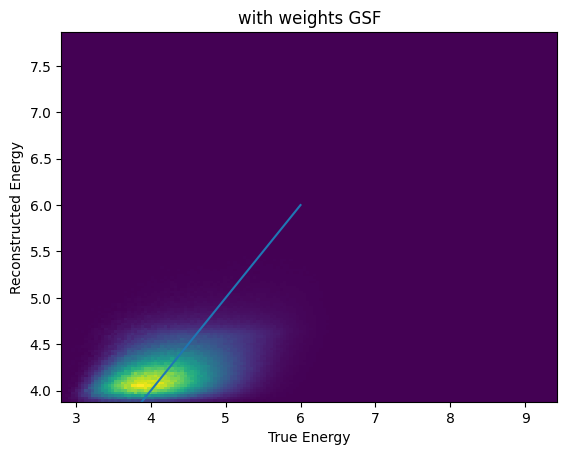

In [41]:
plt.hist2d(np.log10(ienergy), ireco_energy, bins = 150, weights = weights_h3a)
plt.plot(np.linspace(3,6), np.linspace(3,6))
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights GSF')
plt.show()

## KS Test between HAWC and IceCube data

In [42]:
all_ks_values_gsf = np.load('/data/user/rykore/hawc_icecube_files/all_ks_values_gsf.npy')
all_ks_values_h3a = np.load('/data/user/rykore/hawc_icecube_files/all_ks_values_h3a.npy')
best_ks_values_gsf = np.load('/data/user/rykore/hawc_icecube_files/best_ks_values_gsf.npy')
best_ks_values_h3a = np.load('/data/user/rykore/hawc_icecube_files/best_ks_values_h3a.npy')
energy_ranges_gsf = np.load('/data/user/rykore/hawc_icecube_files/energy_ranges_gsf.npy')
energy_ranges_h3a = np.load('/data/user/rykore/hawc_icecube_files/energy_ranges_h3a.npy')

In [43]:
windows = 1000
emin_range = np.linspace(3.0, 8.0, windows)
window_width = 0.25

In [63]:
# for loop for iterating over all hawc windows
start = time.time()
for i, cut in enumerate(cuts):
    print(f"bin {i}")
    hawc_rigidity = rigidity[cut]
    hawc_weights_gsf = gsf[cut]
    hawc_weights_h3a = h3a[cut]

    ks_values_gsf = np.full(windows, np.nan)
    ks_values_h3a = np.full(windows, np.nan)

    for j, emin in enumerate(emin_range):
        emax = emin + window_width
        icut = np.logical_and(ireco_energy >= emin, ireco_energy < emax)
        irigidity_cut = irigidity[icut]
        weights_gsf_cut = weights_gsf[icut]
        weights_h3a_cut = weights_h3a[icut]
        ks_val_gsf = ks_w2(hawc_rigidity, irigidity_cut, hawc_weights_gsf, weights_gsf_cut)
        ks_val_h3a = ks_w2(hawc_rigidity, irigidity_cut, hawc_weights_h3a, weights_h3a_cut)
        ks_values_gsf[j] = ks_val_gsf
        ks_values_h3a[j] = ks_val_h3a

    all_ks_values_gsf.append(ks_values_gsf)
    all_ks_values_h3a.append(ks_values_h3a)

    best_ks_idx_gsf = np.nanargmin(ks_values_gsf)
    best_ks_idx_h3a = np.nanargmin(ks_values_h3a)
    
    best_ks_values_gsf.append(ks_values_gsf[best_ks_idx_gsf])
    emin_gsf = emin_range[best_ks_idx_gsf]
    emax_gsf = emin_range[best_ks_idx_gsf] + 0.25
    energy_ranges_gsf.append([emin_gsf, emax_gsf])
    
    best_ks_values_h3a.append(ks_values_h3a[best_ks_idx_h3a])
    emin_h3a = emin_range[best_ks_idx_h3a]
    emax_h3a = emin_range[best_ks_idx_h3a] + 0.25
    energy_ranges_h3a.append([emin_h3a, emax_h3a])
    
    print('done')

end = time.time()
print(f"time required {(end - start)/60} minutes")

bin 0
done
bin 1
done
bin 2
done
bin 3
done
bin 4
done
bin 5
done
bin 6
done
bin 7
done
bin 8
done
bin 9
done
bin 10
done
bin 11
done
time required 18.719519885381064 minutes


In [45]:
# # save the arrays you need using np.save() and use it later
# step_size = max(1, len(candidate_start_idx) // 1000)
# refine_margin = 1000
# candidate_indices_coarse = np.arange(0, len(candidate_start_idx), step_size)
# all_ks_gsf = []
# all_ks_h3a = []
# best_ks_gsf = []
# best_ks_h3a = []
# energy_ranges_gsf = []
# energy_ranges_h3a = []

# start = time.time()
# for i, cut in enumerate(cuts):
#     print("cut ", i)
#     hawc_rigidity = rigidity[cut]
#     hawc_weights_gsf = gsf[cut]
#     hawc_weights_h3a = h3a[cut]

#     ks_value_gsf = np.full(len(candidate_indices_coarse), np.nan)
#     ks_value_h3a = np.full(len(candidate_indices_coarse), np.nan)

#     # coarse search
#     for i, cand_idx in enumerate(candidate_indices_coarse):
#         i_start = candidate_start_idx[cand_idx]
#         i_end = candidate_end_idx[cand_idx]
#         cand_rig = irigidity[i_start:i_end]
#         cand_w_gsf = weights_gsf[i_start:i_end]
#         cand_w_h3a = weights_h3a[i_start:i_end]

#         if cand_rig.size == 0:
#             continue

#         ks_val_gsf = ks_w2(hawc_rigidity, cand_rig, hawc_weights_gsf, cand_w_gsf)
#         ks_val_h3a = ks_w2(hawc_rigidity, cand_rig, hawc_weights_h3a, cand_w_h3a)
#         ks_value_gsf[i] = ks_val_gsf
#         ks_value_h3a[i] = ks_val_h3a

#     # this will give all the ks values for all the bins
#     all_ks_gsf.append(ks_value_gsf)
#     all_ks_h3a.append(ks_value_h3a)
#     best_idx_gsf = np.nanargmin(ks_value_gsf)
#     best_idx_h3a = np.nanargmin(ks_value_h3a)
#     best_cand_gsf = candidate_indices_coarse[best_idx_gsf]
#     best_cand_h3a = candidate_indices_coarse[best_idx_h3a]

#     # refined search on the just found best_candidate
#     refine_start_gsf = max(0, best_cand_gsf - refine_margin)
#     refine_start_h3a = max(0, best_cand_h3a - refine_margin)
#     refine_end_gsf = min(len(candidate_start_idx), best_cand_gsf + refine_margin)
#     refine_end_h3a = min(len(candidate_start_idx), best_cand_h3a + refine_margin)
#     refined_ks_gsf = np.full(refine_end_gsf - refine_start_gsf, np.nan)
#     refined_ks_h3a = np.full(refine_end_h3a - refine_start_h3a, np.nan)

#     for j, cand_id in enumerate(range(refine_start_gsf, refine_end_gsf)):
#         i_start = candidate_start_idx[cand_id]
#         i_end = candidate_end_idx[cand_id]
#         cand_rig = irigidity[i_start:i_end]
#         cand_w = weights_gsf[i_start:i_end]
        
#         if cand_rig.size == 0:
#             continue

#         ks_val_gsf = ks_w2(hawc_rigidity, cand_rig, hawc_weights_gsf, cand_w)
#         refined_ks_gsf[j] = ks_val_gsf

#     for j, cand_id in enumerate(range(refine_start_h3a, refine_end_h3a)):
#         i_start = candidate_start_idx[cand_id]
#         i_end = candidate_end_idx[cand_id]
#         cand_rig = irigidity[i_start:i_end]
#         cand_w = weights_h3a[i_start:i_end]

#         if cand_rig.size == 0:
#             continue

#         ks_val_h3a = ks_w2(hawc_rigidity, cand_rig, hawc_weights_h3a, cand_w)
#         refined_ks_h3a[j] = ks_val_h3a

#     # get and store the best ks statistic
#     refined_best_idx_gsf = np.nanargmin(refined_ks_gsf)
#     refined_best_idx_h3a = np.nanargmin(refined_ks_h3a)
#     refined_best_cand_gsf = refine_start_gsf + refined_best_idx_gsf
#     refined_best_cand_h3a = refine_start_h3a + refined_best_idx_h3a
#     best_ks_val_gsf = refined_ks_gsf[refined_best_idx_gsf]
#     best_ks_val_h3a = refined_ks_h3a[refined_best_idx_h3a]
#     best_ks_gsf.append(best_ks_val_gsf)
#     best_ks_h3a.append(best_ks_val_h3a)

#     # get the final energy ranges
#     i_start_final_gsf = candidate_start_idx[refined_best_cand_gsf]
#     i_end_final_gsf = candidate_end_idx[refined_best_cand_gsf]
#     i_start_final_h3a = candidate_start_idx[refined_best_cand_h3a]
#     i_end_final_h3a = candidate_end_idx[refined_best_cand_h3a]
#     energy_ranges_gsf.append([ireco_energy[i_start_final_gsf], ireco_energy[i_end_final_gsf]])
#     energy_ranges_h3a.append([ireco_energy[i_start_final_h3a], ireco_energy[i_end_final_h3a]])
#     print()

# end = time.time()
# print("total time: ", (end - start)/60, " minutes")

In [51]:
for bin_idx, (best_val, range_val) in enumerate(zip(best_ks_gsf, energy_ranges_gsf)):
    print(f"HAWC bin {bin_idx}: Best KS = {best_val}, Energy Range = [{range_val[0]}, {range_val[1]}]")

HAWC bin 0: Best KS = 0.8556793960585414, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 1: Best KS = 0.7524258622726422, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 2: Best KS = 0.5672984914330614, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 3: Best KS = 0.33497990253727633, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 4: Best KS = 0.12068890455146353, Energy Range = [3.8806605339050293, 4.130676746368408]
HAWC bin 5: Best KS = 0.06137501402904344, Energy Range = [4.030068874359131, 4.28007173538208]
HAWC bin 6: Best KS = 0.06523097671099531, Energy Range = [4.344851970672607, 4.59486198425293]
HAWC bin 7: Best KS = 0.08814590157150493, Energy Range = [4.639890670776367, 4.889894485473633]
HAWC bin 8: Best KS = 0.09867657923164863, Energy Range = [4.996903896331787, 5.246922016143799]
HAWC bin 9: Best KS = 0.1030992785805277, Energy Range = [5.403433799743652, 5.653448581695557]
HAWC bin 10: Best KS = 0.1074236297

In [52]:
for bin_idx, (best_val, range_val) in enumerate(zip(best_ks_h3a, energy_ranges_h3a)):
    print(f"HAWC bin {bin_idx}: Best KS = {best_val}, Energy Range = [{range_val[0]}, {range_val[1]}]")

HAWC bin 0: Best KS = 0.8495873513813781, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 1: Best KS = 0.7474126912347235, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 2: Best KS = 0.5634548494393196, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 3: Best KS = 0.3332005810867545, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 4: Best KS = 0.1222988629715509, Energy Range = [3.880659818649292, 4.130676746368408]
HAWC bin 5: Best KS = 0.06878407656526098, Energy Range = [4.04335880279541, 4.293362140655518]
HAWC bin 6: Best KS = 0.07575042850896574, Energy Range = [4.36287784576416, 4.612880229949951]
HAWC bin 7: Best KS = 0.10407218428811893, Energy Range = [4.667209625244141, 4.9172186851501465]
HAWC bin 8: Best KS = 0.11278386614297309, Energy Range = [5.03125, 5.281296730041504]
HAWC bin 9: Best KS = 0.112105173212115, Energy Range = [5.409143924713135, 5.659172534942627]
HAWC bin 10: Best KS = 0.1092354621971664, Energ

In [79]:
# save all the arrays just calculated
np.save('/data/user/rykore/hawc_icecube_files/all_ks_values_gsf.npy', all_ks_values_gsf)
np.save('/data/user/rykore/hawc_icecube_files/all_ks_values_h3a.npy', all_ks_values_h3a)
np.save('/data/user/rykore/hawc_icecube_files/best_ks_values_gsf.npy', best_ks_values_gsf)
np.save('/data/user/rykore/hawc_icecube_files/best_ks_values_h3a.npy', best_ks_values_h3a)
np.save('/data/user/rykore/hawc_icecube_files/energy_ranges_gsf.npy', energy_ranges_gsf)
np.save('/data/user/rykore/hawc_icecube_files/energy_ranges_h3a.npy', energy_ranges_h3a)

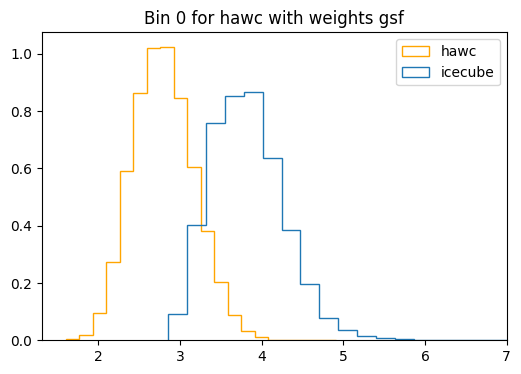

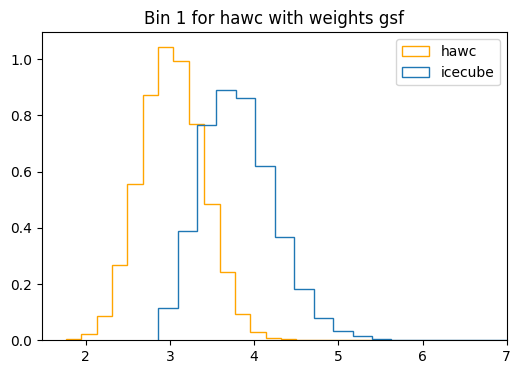

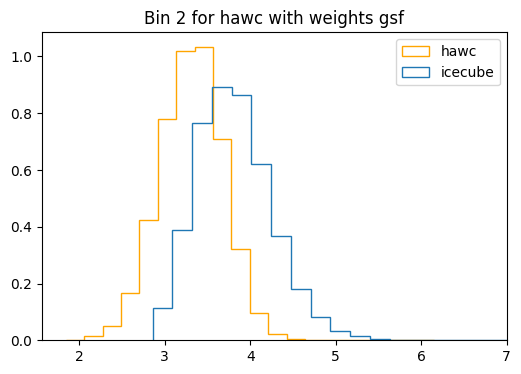

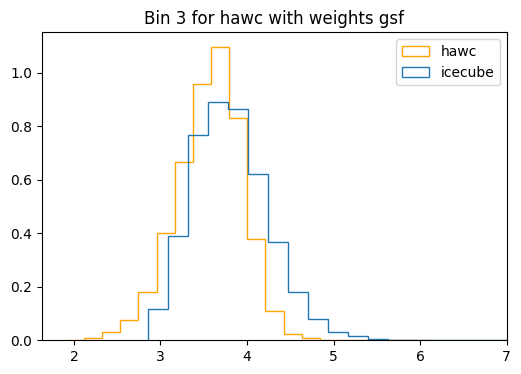

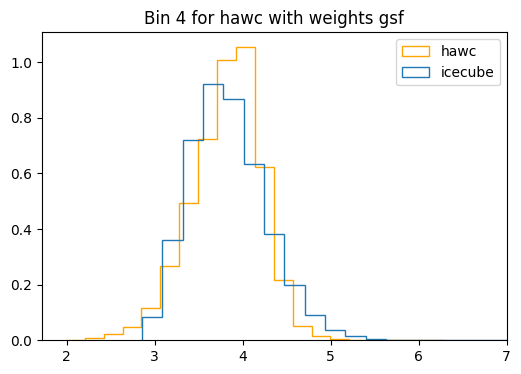

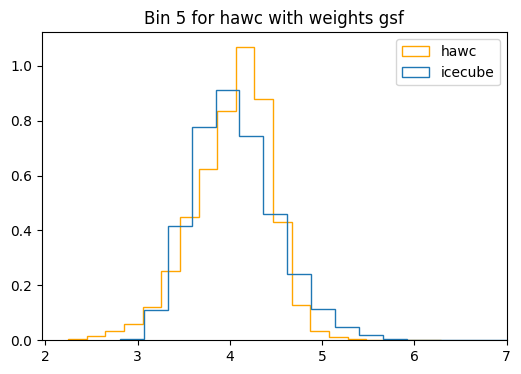

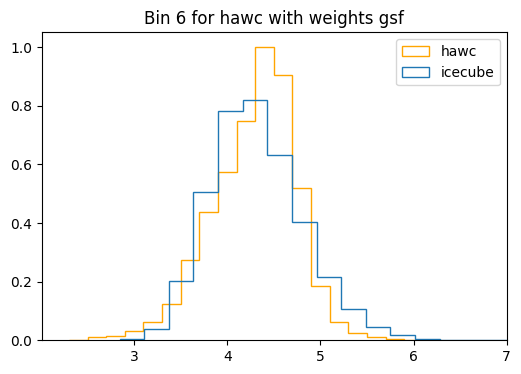

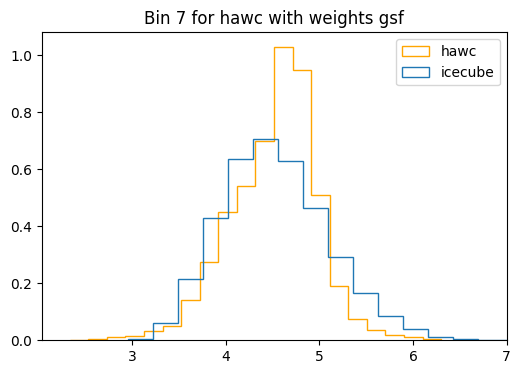

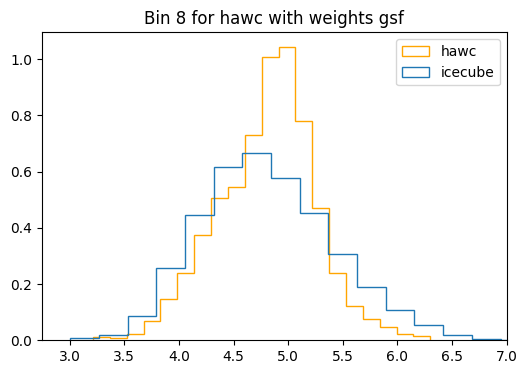

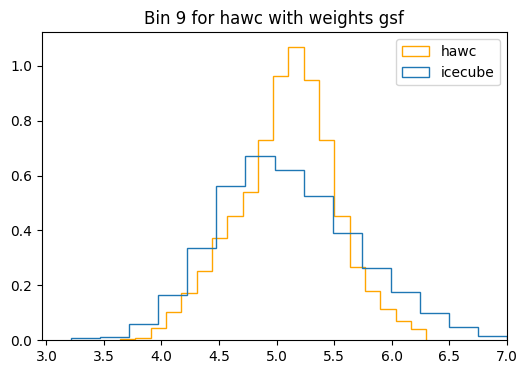

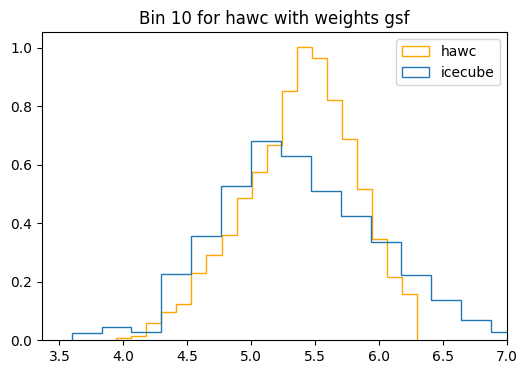

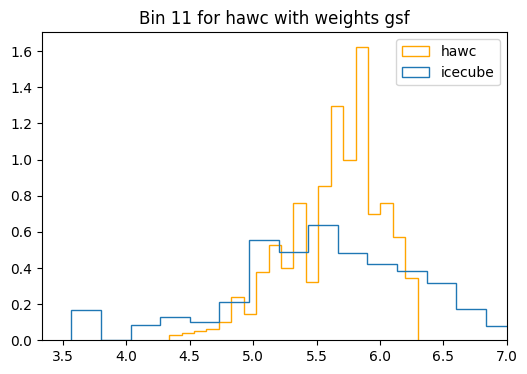

In [44]:
# gsf
for i, (cut, energy_range) in enumerate(zip(cuts, energy_ranges_gsf)):
    icut = np.logical_and(ireco_energy >= energy_range[0], ireco_energy < energy_range[1])
    plt.figure(figsize = (6,4))
    plt.hist(np.log10(rigidity[cut]), bins = 20, weights = gsf[cut], histtype = 'step', density = True, label = 'hawc', color = 'orange')
    plt.hist(np.log10(irigidity[icut]), bins = 20, weights = weights_gsf[icut], histtype = 'step', density = True, label = 'icecube')
    plt.xlim(right = 7.0)
    plt.legend()
    plt.title(f"Bin {i} for hawc with weights gsf")
    plt.show()

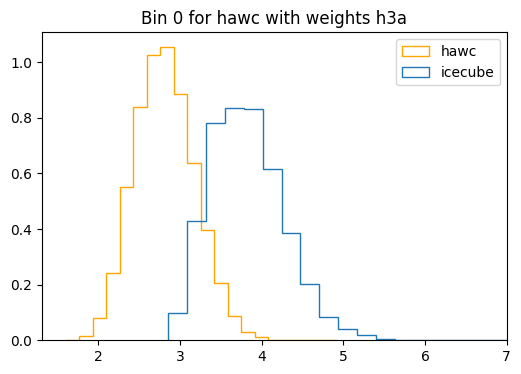

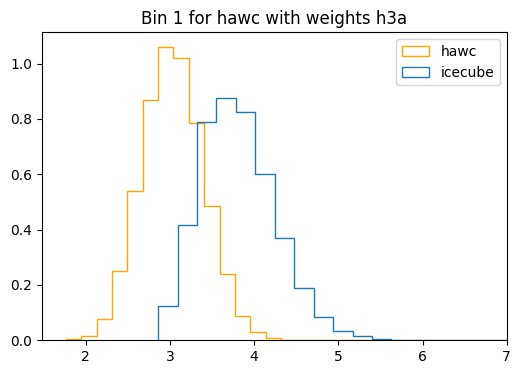

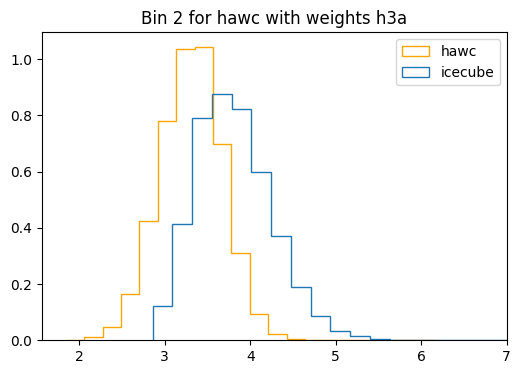

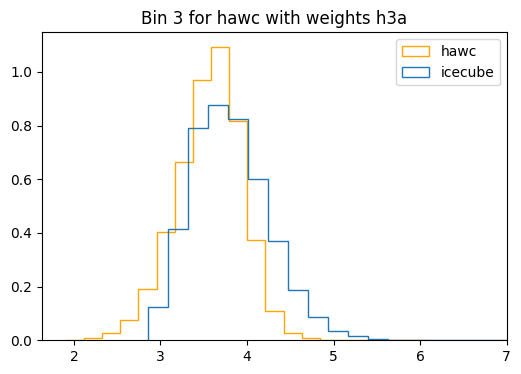

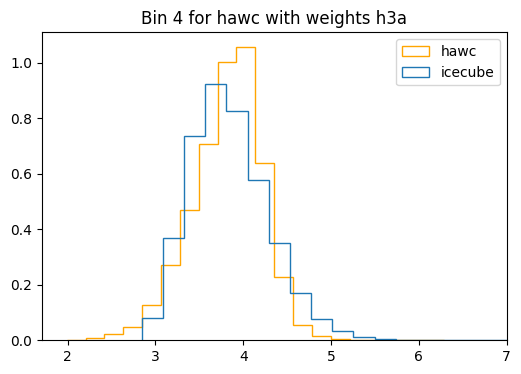

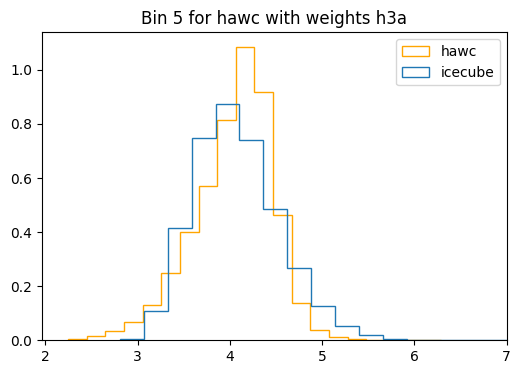

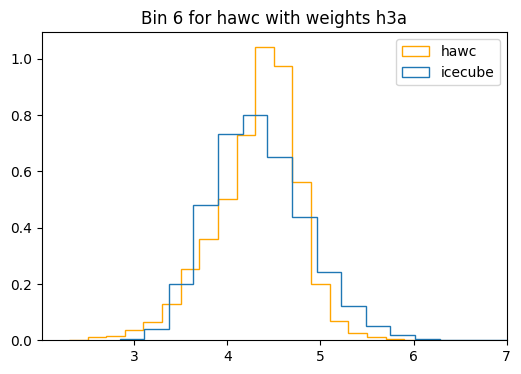

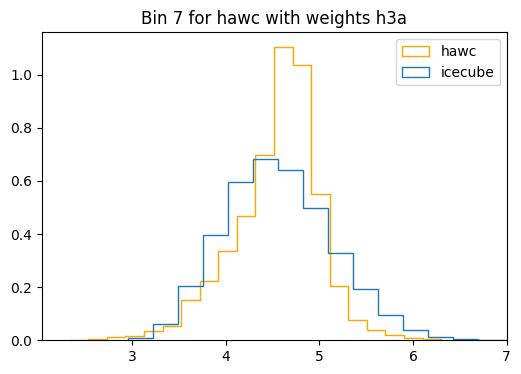

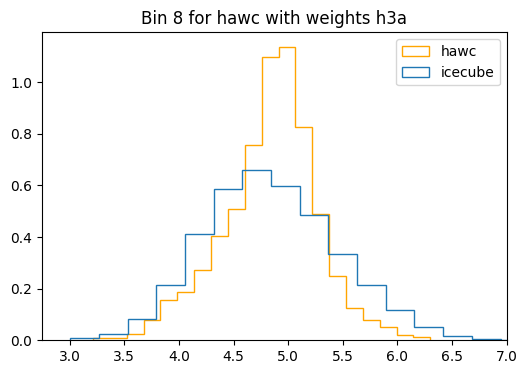

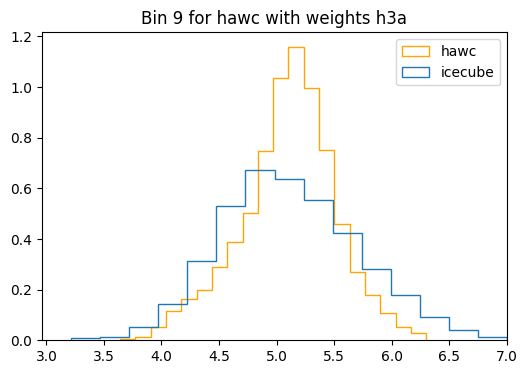

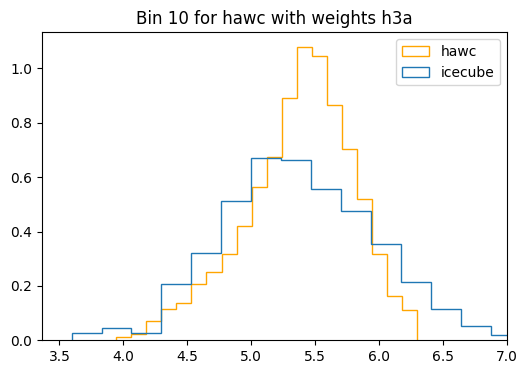

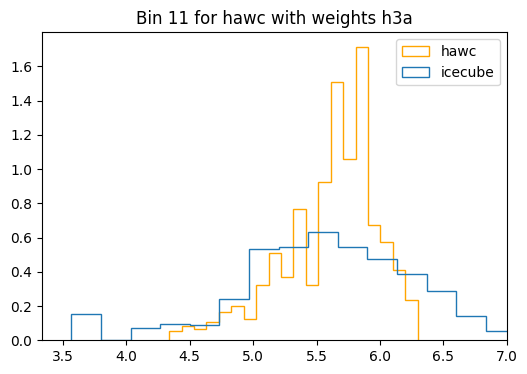

In [45]:
# h3a
for i, (cut, energy_range) in enumerate(zip(cuts, energy_ranges_h3a)):
    icut = np.logical_and(ireco_energy >= energy_range[0], ireco_energy < energy_range[1])
    plt.figure(figsize = (6,4))
    plt.hist(np.log10(rigidity[cut]), bins = 20, weights = h3a[cut], histtype = 'step', density = True, label = 'hawc', color = 'orange')
    plt.hist(np.log10(irigidity[icut]), bins = 20, weights = weights_h3a[icut], histtype = 'step', density = True, label = 'icecube')
    plt.xlim(right = 7.0)
    plt.legend()
    plt.title(f"Bin {i} for hawc with weights h3a")
    plt.show()

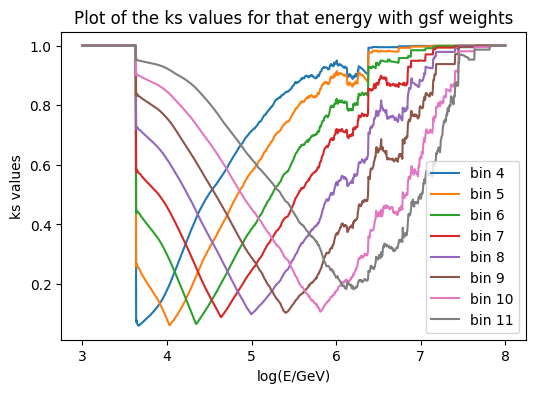

In [46]:
plt.figure(figsize = (6,4))
for i, ks in enumerate(all_ks_values_gsf):
    if i > 3:
        plt.plot(emin_range, ks, label = f"bin {i}")

plt.legend()
plt.title('Plot of the ks values for that energy with gsf weights')
plt.xlabel('log(E/GeV)')
plt.ylabel('ks values')
plt.show()

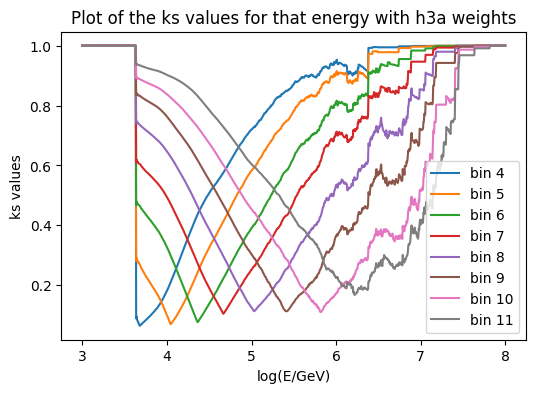

In [47]:
plt.figure(figsize = (6,4))
for i, ks in enumerate(all_ks_values_h3a):
    if i > 3:
        plt.plot(emin_range, ks, label = f"bin {i}")

plt.legend()
plt.title('Plot of the ks values for that energy with h3a weights')
plt.xlabel('log(E/GeV)')
plt.ylabel('ks values')
plt.show()

## Energy cuts on reco energy and apply that on true energy

In [48]:
def cut_ienergy(min_energy, max_energy):
    icut = np.logical_and(ireco_energy >= min_energy, ireco_energy < max_energy)
    return icut

### gsf cuts

In [49]:
icuts_gsf = []

for e_range in energy_ranges_gsf:
    icut = cut_ienergy(e_range[0], e_range[1])
    icuts_gsf.append(icut)

### h3a cuts

In [50]:
icuts_h3a = []

for e_range in energy_ranges_h3a:
    icut = cut_ienergy(e_range[0], e_range[1])
    icuts_h3a.append(icut)

### gsf mean rigidity

In [51]:
imean_rigs_gsf = []

for i, icut in enumerate(icuts_gsf):
    imean_rig_gsf = np.average(irigidity[icut], weights = weights_gsf[icut])
    imean_rigs_gsf.append(imean_rig_gsf)

imean_rigs_gsf = np.array(imean_rigs_gsf)

In [52]:
imean_rigs_gsf

array([  13052.62141932,   12318.64253512,   12318.64253512,
         12318.64253512,   12808.96892317,   22545.0982423 ,
         45767.88307587,   90441.48608883,  194105.93473128,
        386030.09601285,  743198.6987858 , 1330082.82622445])

### h3a mean rigidity

In [53]:
imean_rigs_h3a = []

for i, icut in enumerate(icuts_h3a):
    imean_rig_h3a = np.average(irigidity[icut], weights = weights_h3a[icut])
    imean_rigs_h3a.append(imean_rig_h3a)

imean_rigs_h3a = np.array(imean_rigs_h3a)

In [54]:
imean_rigs_h3a

array([  13093.01349752,   12358.33761595,   12358.33761595,
         12358.33761595,   13270.91374172,   23688.79846056,
         48035.65911409,   95300.63722349,  197459.74112276,
        360565.15110142,  637587.36811261, 1076669.91193132])

### gsf mean energies

In [55]:
imean_energies_gsf = []

for i, icut in enumerate(icuts_gsf):
    imean_energy_gsf = np.average(ienergy[icut], weights = weights_gsf[icut])
    imean_energies_gsf.append(imean_energy_gsf)

imean_energies_gsf = np.array(imean_energies_gsf)

In [56]:
imean_energies_gsf

array([  20555.40234832,   19350.75677611,   19350.75677611,
         19350.75677611,   20291.49247804,   36243.2298684 ,
         77386.24545976,  164462.98052532,  384005.36929697,
        842628.80930386, 1828915.93575662, 3592567.59476412])

### h3a mean energies

In [57]:
imean_energies_h3a = []

for i, icut in enumerate(icuts_h3a):
    imean_energy_h3a = np.average(ienergy[icut], weights = weights_h3a[icut])
    imean_energies_h3a.append(imean_energy_h3a)

imean_energies_h3a = np.array(imean_energies_h3a)

In [58]:
imean_energies_h3a

array([  19853.44771577,   18680.02435307,   18680.02435307,
         18680.02435307,   20335.91274738,   37009.78750068,
         80674.21098464,  179296.71132572,  437178.90520979,
        954534.93683742, 2124395.60700928, 4157845.97948011])

### gsf mean atomic

In [59]:
imean_atomics_gsf = []

for i, icut in enumerate(icuts_gsf):
    imean_atomic_gsf = np.average(iatomic[icut], weights = weights_gsf[icut])
    imean_atomics_gsf.append(imean_atomic_gsf)

imean_atomics_gsf = np.array(imean_atomics_gsf)

In [60]:
imean_atomics_gsf

array([1.73136716, 1.70331621, 1.70331621, 1.70331621, 1.71889462,
       1.80095865, 2.04248951, 2.388057  , 2.92773634, 3.73225105,
       4.78316378, 5.44703525])

### h3a mean atomic

In [61]:
imean_atomics_h3a = []

for i, icut in enumerate(icuts_h3a):
    imean_atomic_h3a = np.average(iatomic[icut], weights = weights_h3a[icut])
    imean_atomics_h3a.append(imean_atomic_h3a)

imean_atomics_h3a = np.array(imean_atomics_h3a)

In [62]:
imean_atomics_h3a

array([1.63674318, 1.61009132, 1.61009132, 1.61009132, 1.62824783,
       1.70513018, 1.95578497, 2.36314265, 3.16219599, 4.30449328,
       6.13720855, 7.45118582])

# HAWC + IceCube combined tables

In [63]:
# rigidity and energy bins table
df1 = pd.DataFrame()

df1['HAWC mean rid gsf'] = mean_rig_gsf
df1['HAWC mean rid h3a'] = mean_rig_h3a
df1['HAWC (emin, emax)'] = list(zip(min_energies, max_energies))
df1['IceCube mean rid gsf'] = imean_rigs_gsf
df1['IceCube mean rid h3a'] = imean_rigs_h3a
df1['IceCube (emin, emax) gsf'] = list(energy_ranges_gsf)
df1['IceCube (emin, emax) h3a'] = list(energy_ranges_h3a)
df1

,HAWC mean rid gsf,HAWC mean rid h3a,"HAWC (emin, emax)",IceCube mean rid gsf,IceCube mean rid h3a,"IceCube (emin, emax) gsf","IceCube (emin, emax) h3a"
0,935.904842,954.747172,"(3.0, 3.51)",1.305262e+04,1.309301e+04,"[3.6356356356356354, 3.8856356356356354]","[3.6356356356356354, 3.8856356356356354]"
1,1574.312630,1573.199407,"(3.51, 3.74)",1.231864e+04,1.235834e+04,"[3.6406406406406404, 3.8906406406406404]","[3.6406406406406404, 3.8906406406406404]"
2,2960.499931,2933.307165,"(3.74, 3.98)",1.231864e+04,1.235834e+04,"[3.6406406406406404, 3.8906406406406404]","[3.6406406406406404, 3.8906406406406404]"
3,5316.355869,5306.916589,"(3.98, 4.21)",1.231864e+04,1.235834e+04,"[3.6406406406406404, 3.8906406406406404]","[3.6406406406406404, 3.8906406406406404]"
4,9564.272608,9729.544645,"(4.21, 4.433)",1.280897e+04,1.327091e+04,"[3.6606606606606604, 3.9106606606606604]","[3.6806806806806804, 3.9306806806806804]"
5,16410.599144,16990.455165,"(4.433, 4.648)",2.254510e+04,2.368880e+04,"[4.031031031031031, 4.281031031031031]","[4.046046046046046, 4.296046046046046]"
6,32030.534061,33589.951145,"(4.648, 4.98)",4.576788e+04,4.803566e+04,"[4.346346346346346, 4.596346346346346]","[4.361361361361361, 4.611361361361361]"
7,56296.085485,58785.043499,"(4.88, 5.15)",9.044149e+04,9.530064e+04,"[4.641641641641642, 4.891641641641642]","[4.666666666666667, 4.916666666666667]"
8,107770.715391,110234.996521,"(5.15, 5.44)",1.941059e+05,1.974597e+05,"[4.996996996996997, 5.246996996996997]","[5.032032032032032, 5.282032032032032]"
9,195894.838361,194109.751664,"(5.44, 5.68)",3.860301e+05,3.605652e+05,"[5.402402402402402, 5.652402402402402]","[5.412412412412412, 5.662412412412412]"


In [64]:
# mean energies table
df2 = pd.DataFrame()

df2['HAWC mean energy gsf'] = log_mean_e_gsf
df2['HAWC mean energy h3a'] = log_mean_e_h3a
df2['IceCube mean energy gsf'] = np.log10(imean_energies_gsf)
df2['IceCube mean energy h3a'] = np.log10(imean_energies_h3a)
df2

,HAWC mean energy gsf,HAWC mean energy h3a,IceCube mean energy gsf,IceCube mean energy h3a
0,3.170021,3.167128,4.312926,4.297836
1,3.412459,3.399695,4.286698,4.271377
2,3.712649,3.694169,4.286698,4.271377
3,3.964747,3.949152,4.286698,4.271377
4,4.237054,4.224953,4.307314,4.308264
5,4.481059,4.472286,4.559227,4.568317
6,4.783642,4.778155,4.888664,4.906735
7,5.026138,5.024545,5.216068,5.253572
8,5.294522,5.295257,5.584337,5.640659
9,5.536326,5.538694,5.925636,5.979792


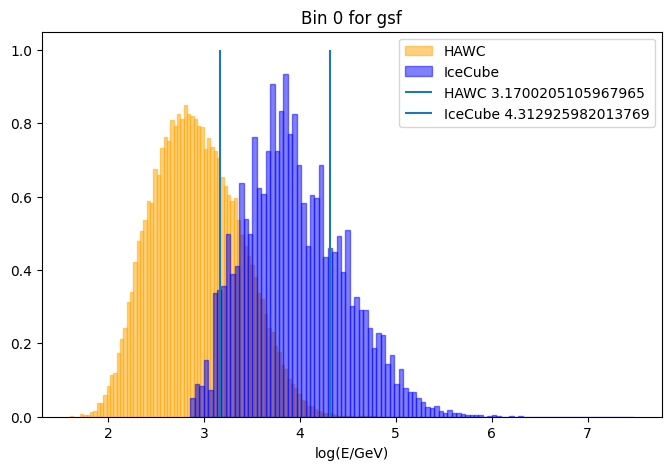

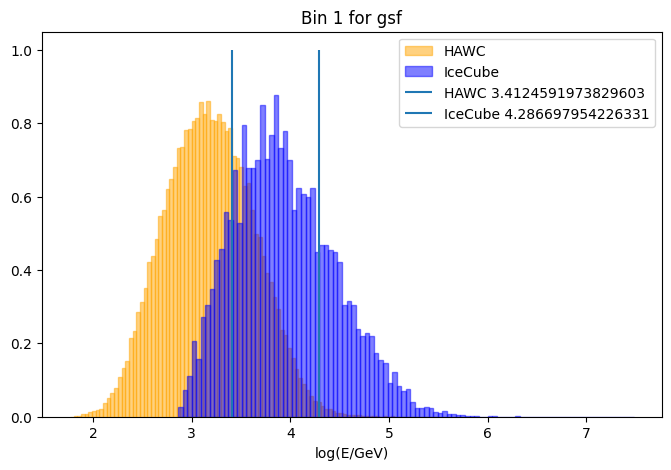

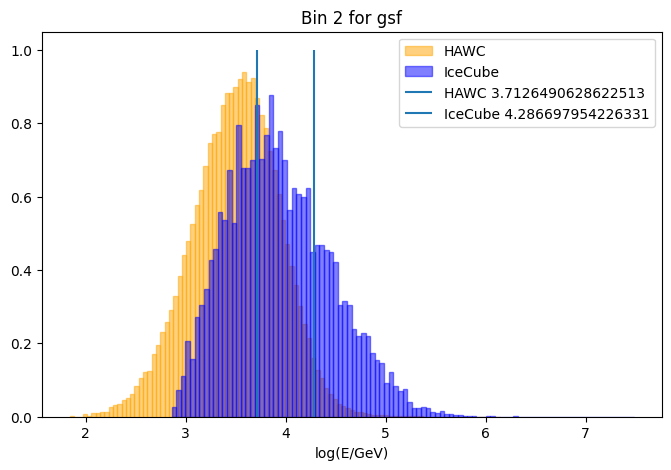

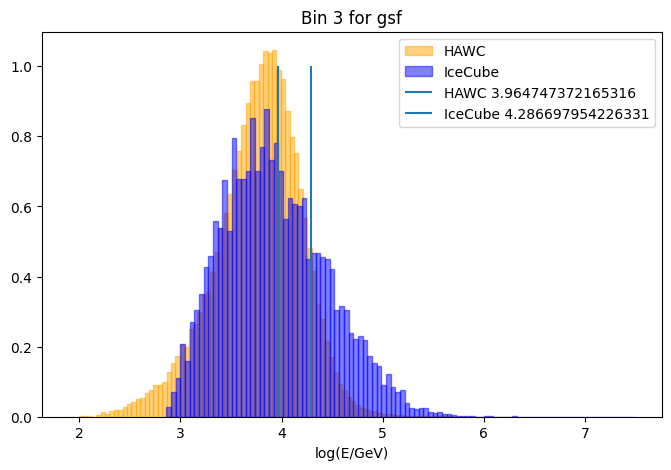

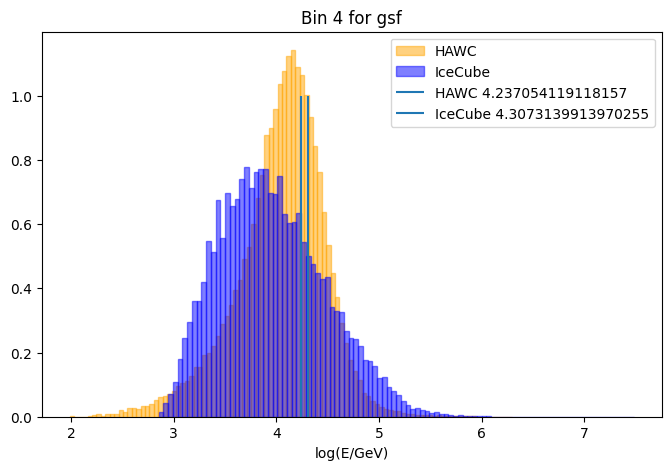

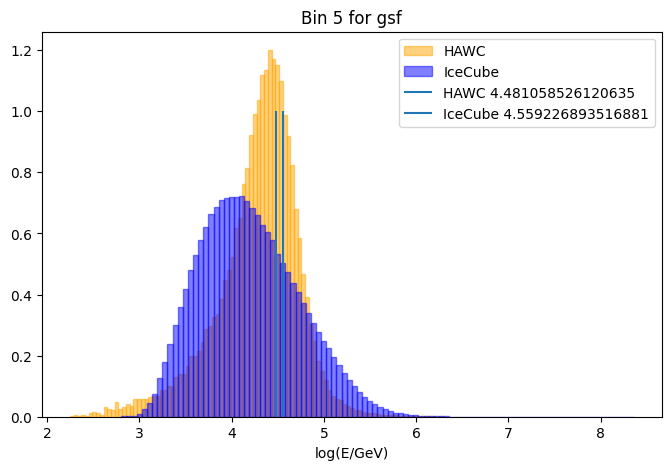

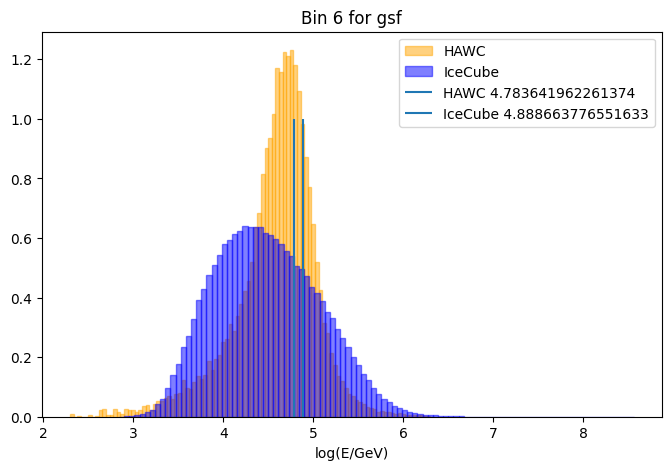

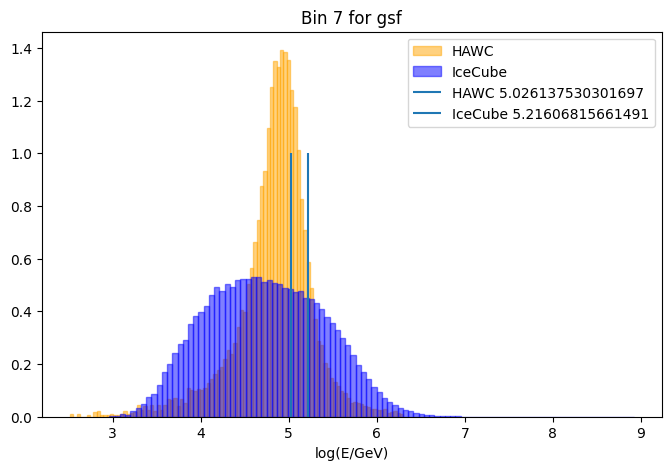

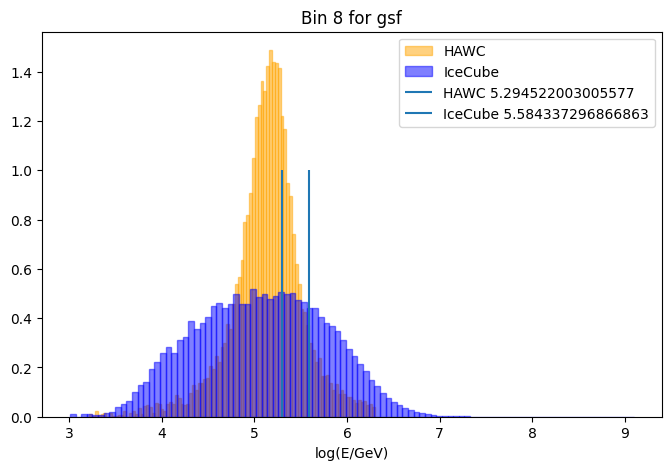

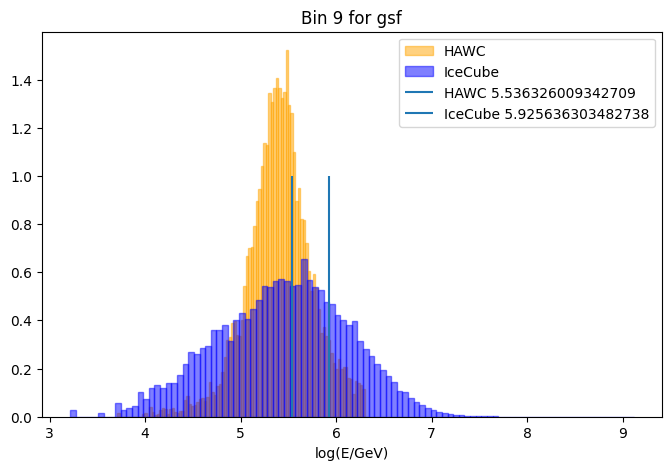

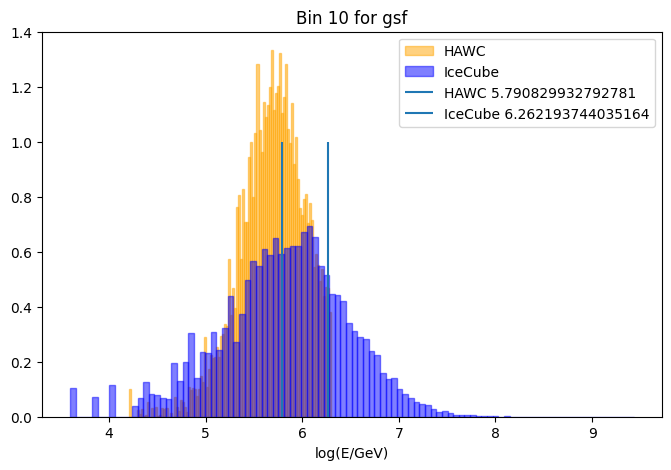

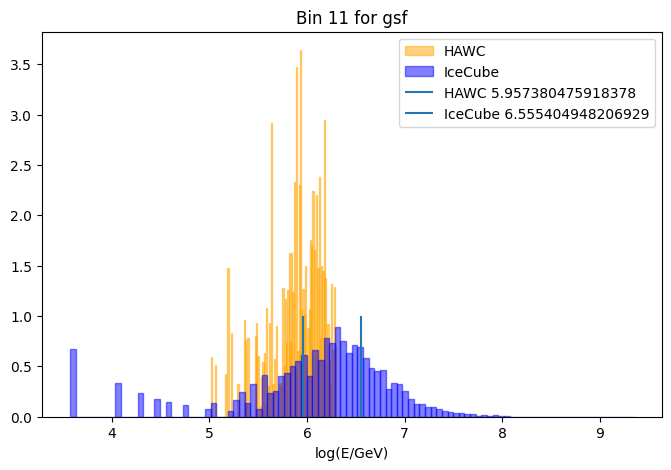

In [65]:
# colors = ["red", "blue", "orange", "green", "purple", "pink", "lime", "indigo", "gold", "yellowgreen", "peru", "rosybrown"]

# gsf
for idx, (i, j, k, l) in enumerate(zip(cuts, icuts_gsf, log_mean_e_gsf ,np.log10(imean_energies_gsf))):
    plt.figure(figsize = (8,5))
    plt.hist(log_true_E[i], bins = 100, weights = gsf[i], label = 'HAWC', alpha = 0.5, edgecolor = 'orange', color = 'orange', density = True)
    plt.hist(np.log10(ienergy[j]), bins = 100, weights = weights_gsf[j], label = 'IceCube', alpha = 0.5, edgecolor = 'blue', color = 'blue', density = True)
    plt.vlines(k, ymin = 0, ymax = 1, label = f"HAWC {k}")
    plt.vlines(l, ymin = 0, ymax = 1, label = f"IceCube {l}")
    plt.legend()
    plt.title(f"Bin {idx} for gsf")
    plt.xlabel('log(E/GeV)')
    plt.show()

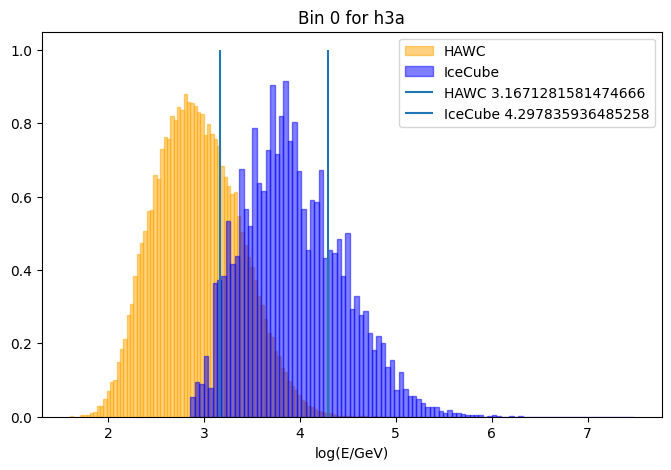

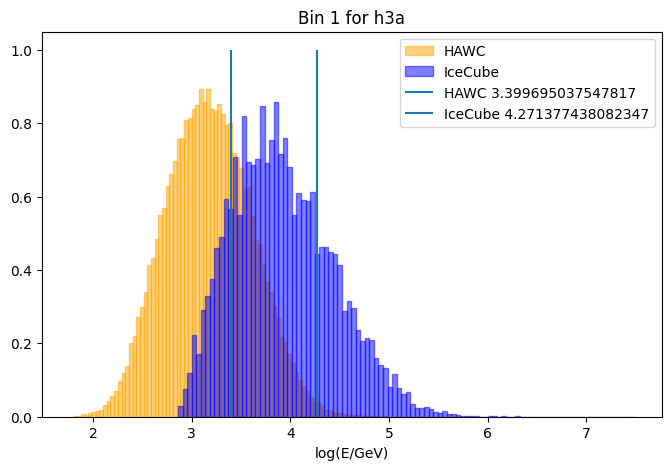

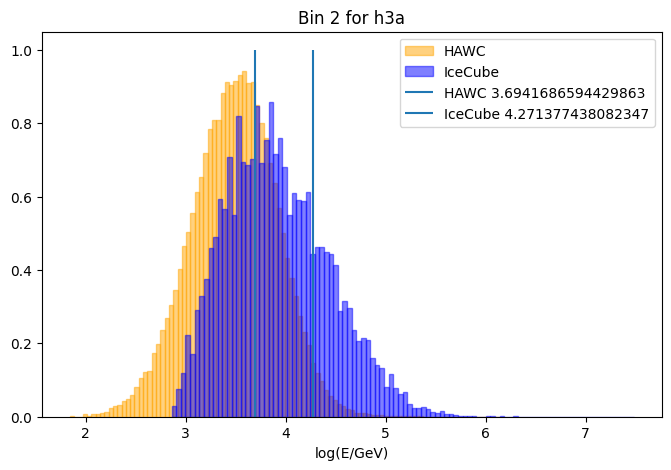

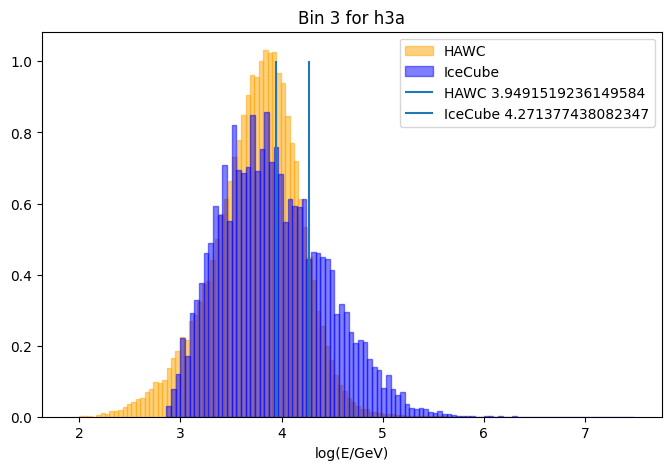

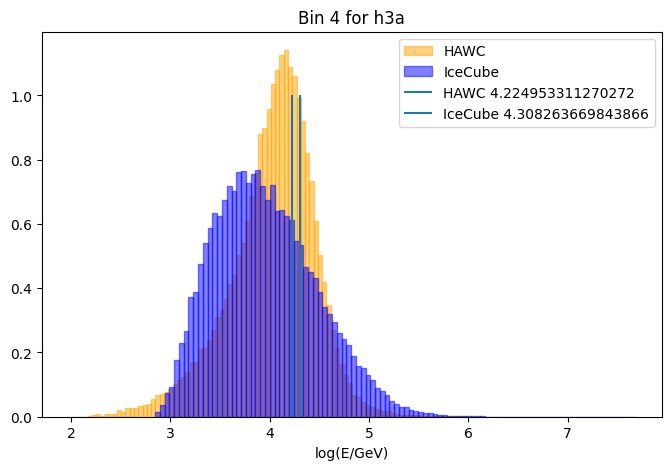

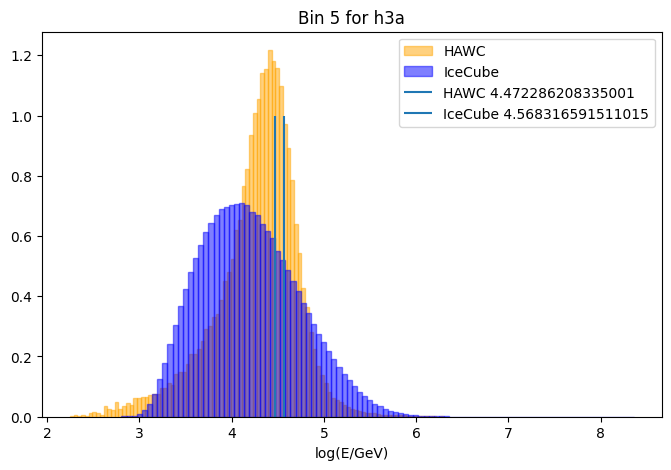

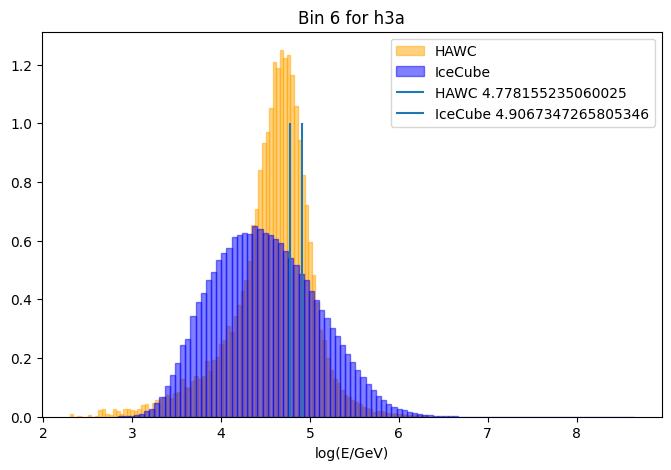

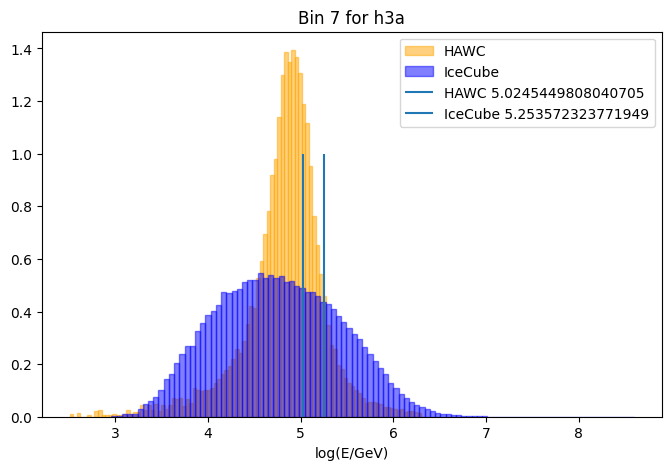

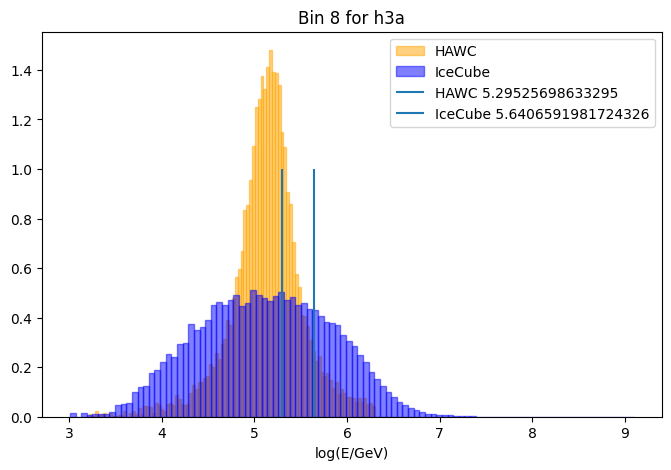

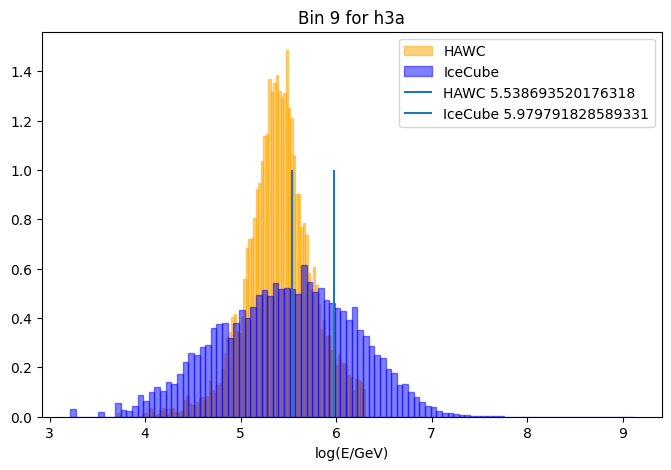

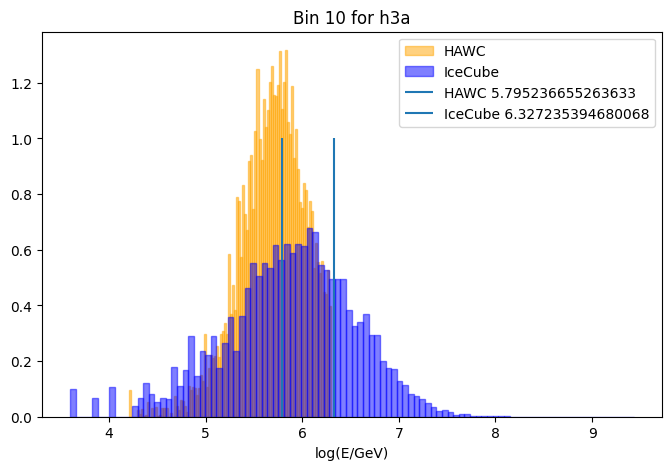

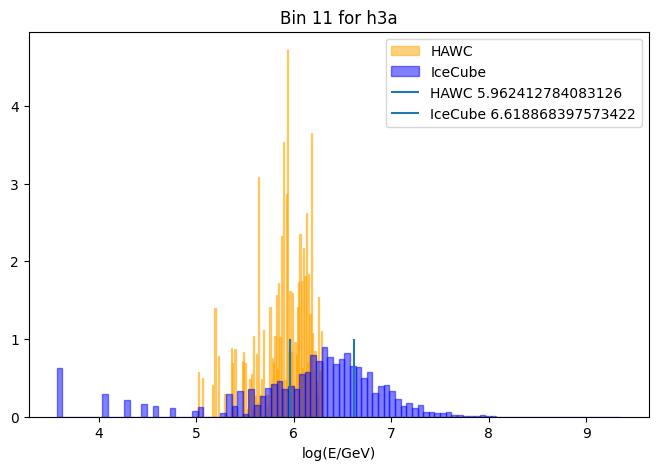

In [83]:
# h3a
for idx, (i, j, k, l) in enumerate(zip(cuts, icuts_h3a, log_mean_e_h3a ,np.log10(imean_energies_h3a))):
    plt.figure(figsize = (8,5))
    plt.hist(log_true_E[i], bins = 100, weights = h3a[i], label = 'HAWC', alpha = 0.5, edgecolor = 'orange', color = 'orange', density = True)
    plt.hist(np.log10(ienergy[j]), bins = 100, weights = weights_h3a[j], label = 'IceCube', alpha = 0.5, edgecolor = 'blue', color = 'blue', density = True)
    plt.vlines(k, ymin = 0, ymax = 1, label = f"HAWC {k}")
    plt.vlines(l, ymin = 0, ymax = 1, label = f"IceCube {l}")
    plt.legend()
    plt.title(f"Bin {idx} for h3a")
    plt.xlabel('log(E/GeV)')
    plt.show()

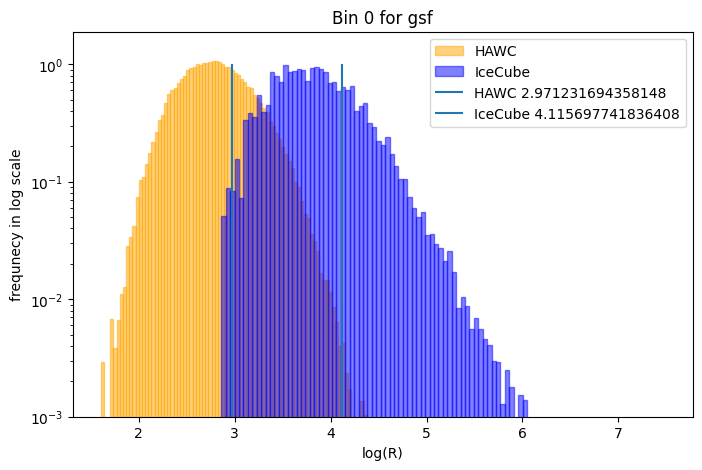

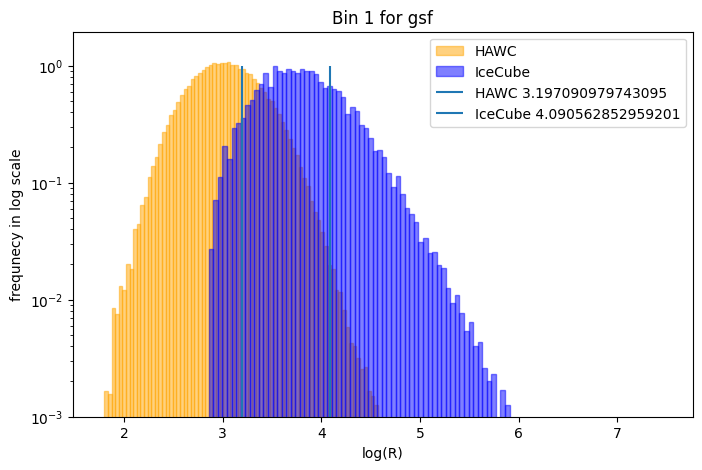

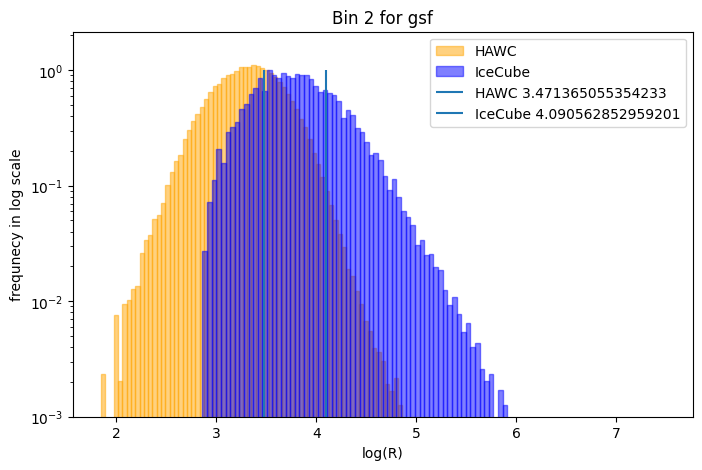

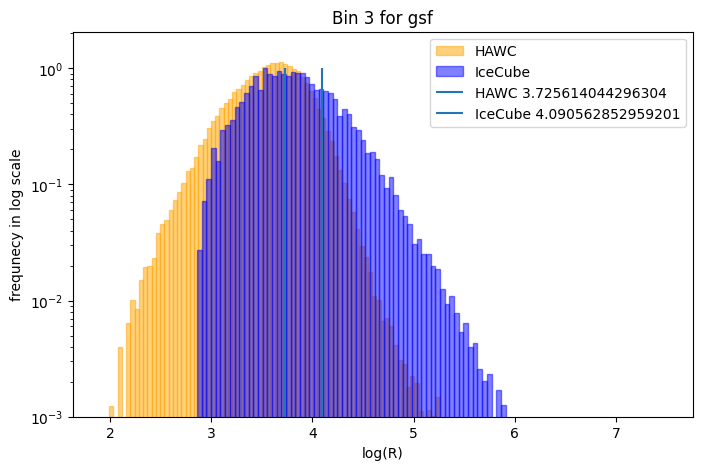

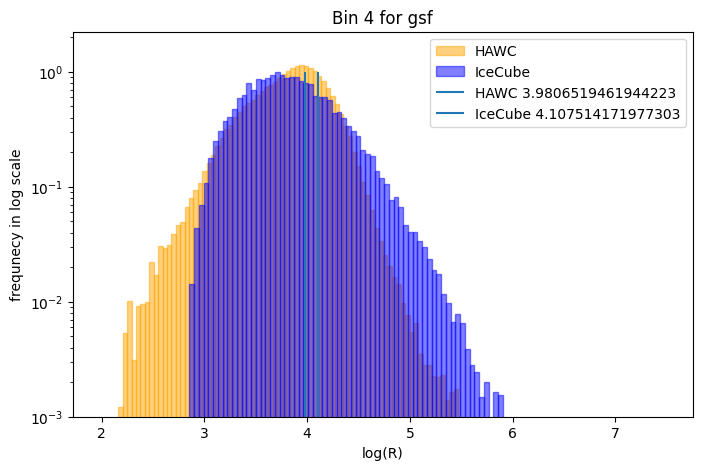

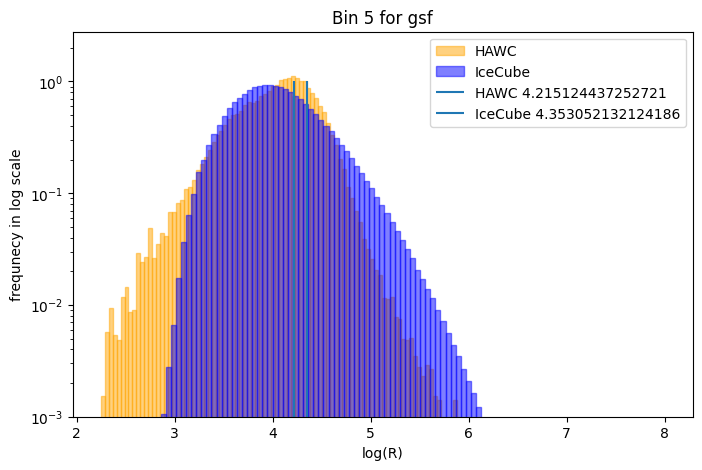

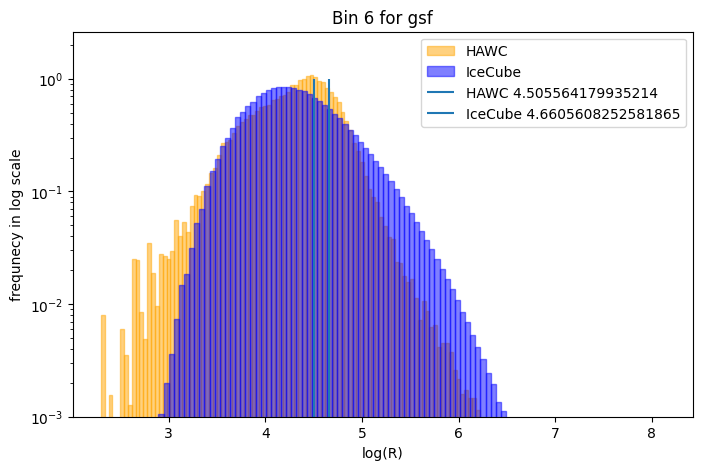

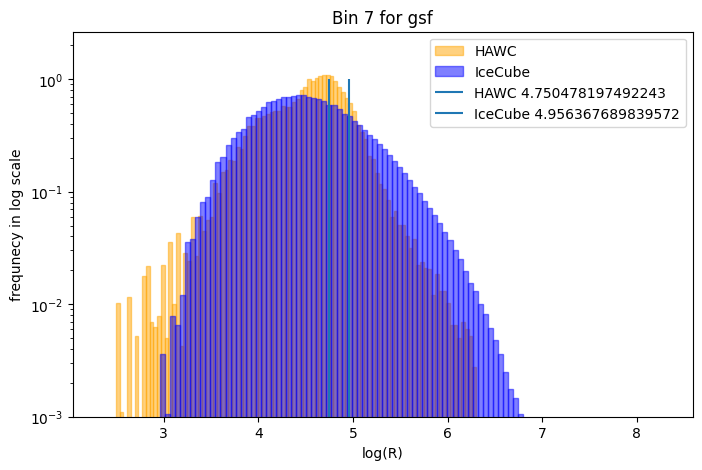

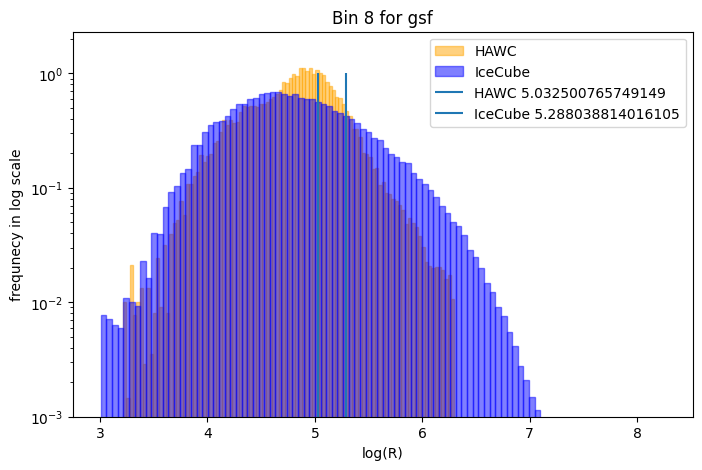

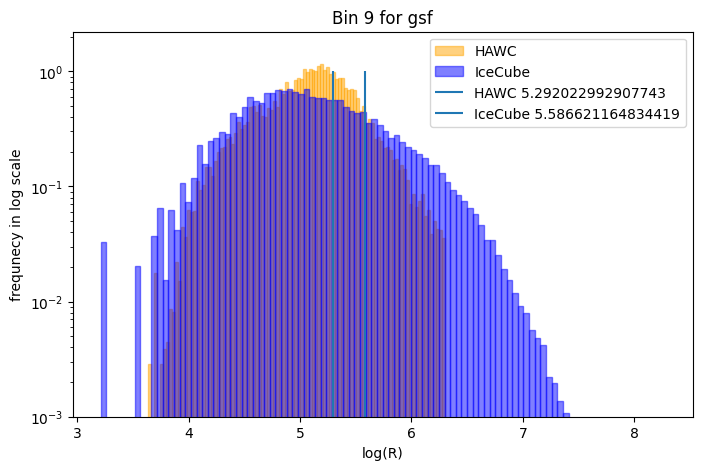

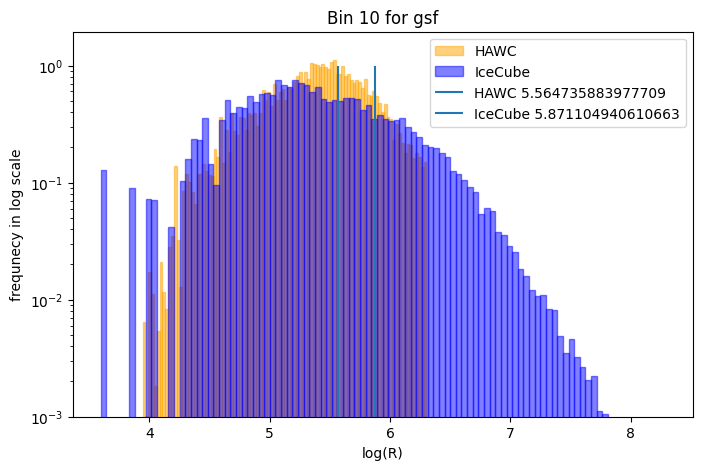

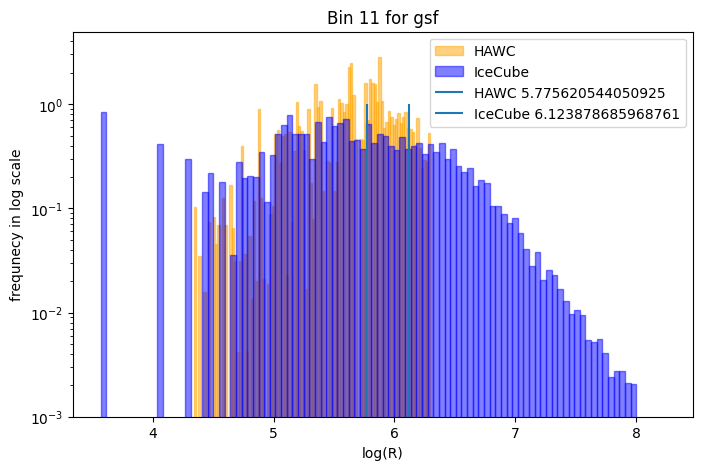

In [84]:
# colors = ["red", "blue", "orange", "green", "purple", "pink", "lime", "indigo", "gold", "yellowgreen", "peru", "rosybrown"]

# gsf
for idx, (i, j, k, l) in enumerate(zip(cuts, icuts_gsf, log_mean_rig_gsf , np.log10(imean_rigs_gsf))):
    plt.figure(figsize = (8,5))
    plt.hist(np.log10(rigidity[i]), bins = 100, weights = gsf[i], label = 'HAWC', alpha = 0.5, edgecolor = 'orange', color = 'orange', density = True)
    plt.hist(np.log10(irigidity[j]), bins = 100, weights = weights_gsf[j], label = 'IceCube', alpha = 0.5, edgecolor = 'blue', color = 'blue', density = True)
    plt.vlines(k, ymin = 0, ymax = 1, label = f"HAWC {k}")
    plt.vlines(l, ymin = 0, ymax = 1, label = f"IceCube {l}")
    plt.semilogy()
    plt.ylim(bottom = 10**-3)
    plt.legend()
    plt.title(f"Bin {idx} for gsf")
    plt.xlabel('log(R)')
    plt.ylabel('frequnecy in log scale')
    plt.show()

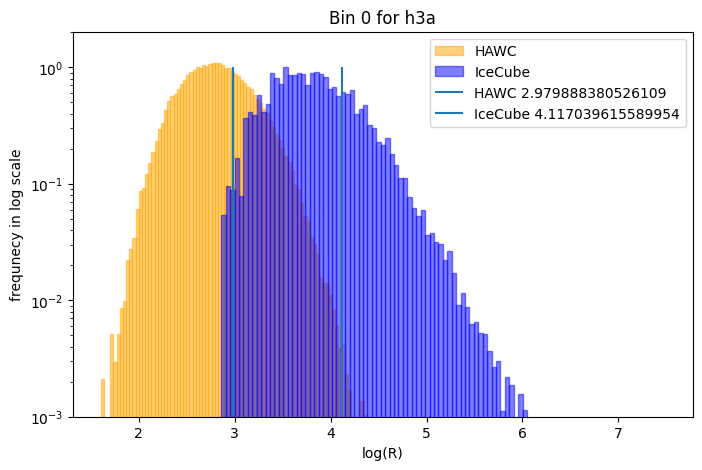

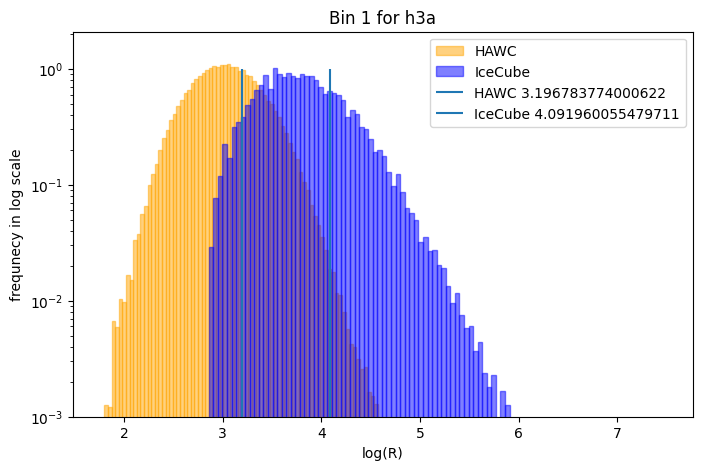

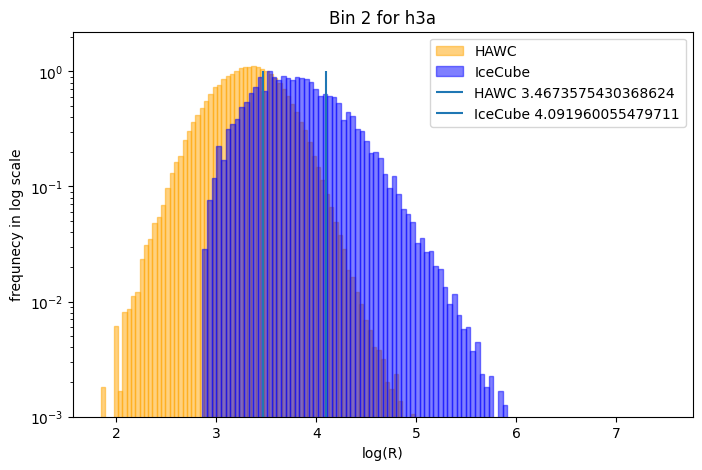

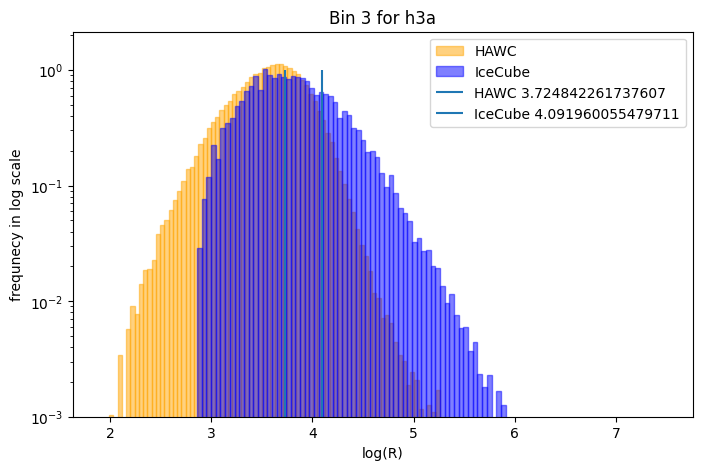

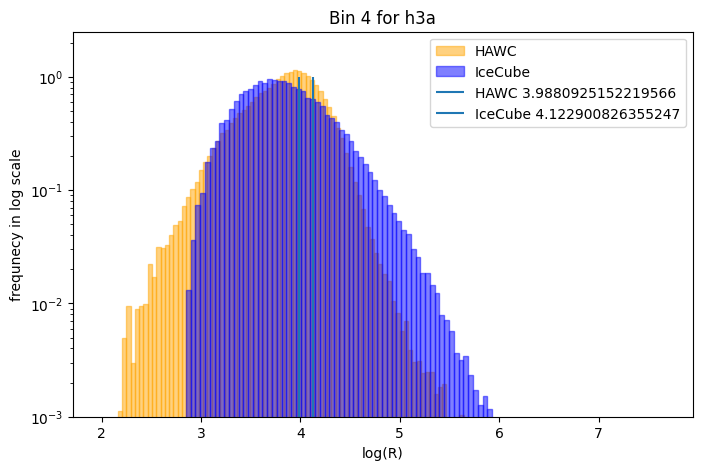

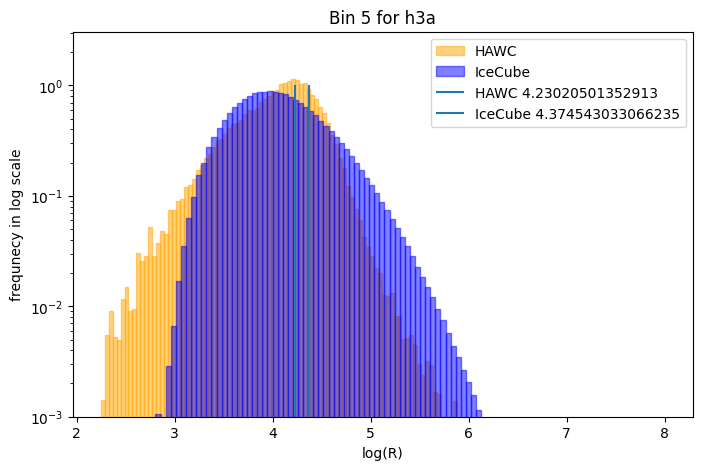

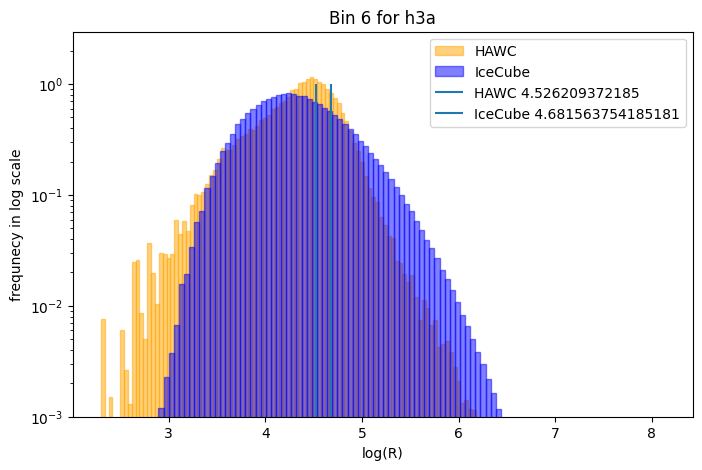

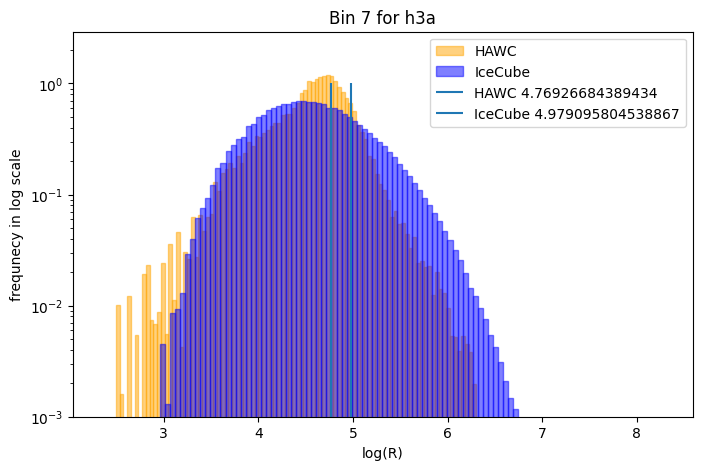

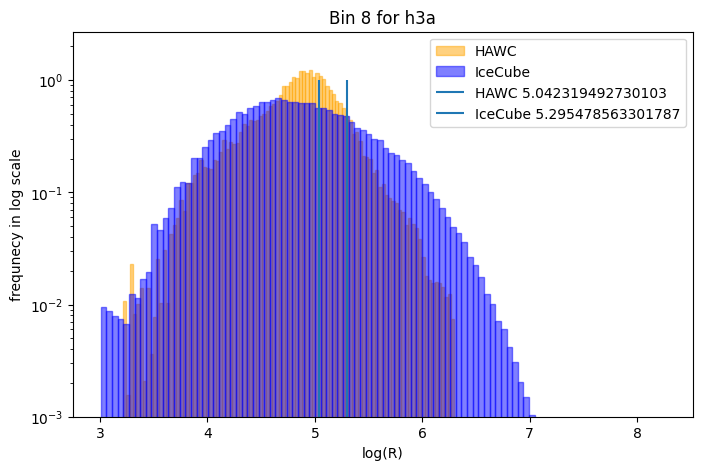

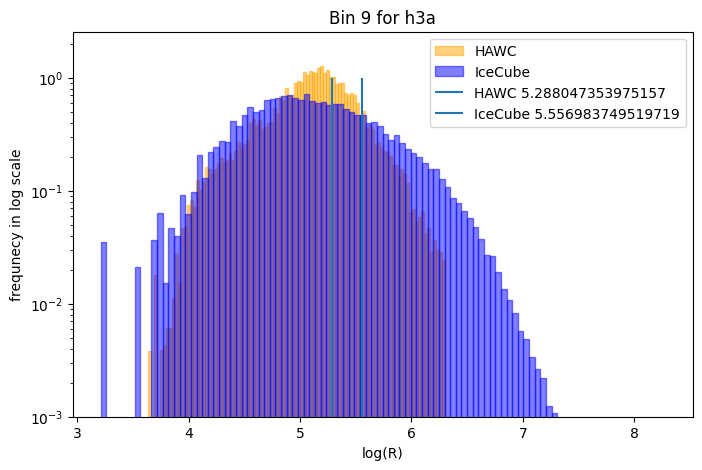

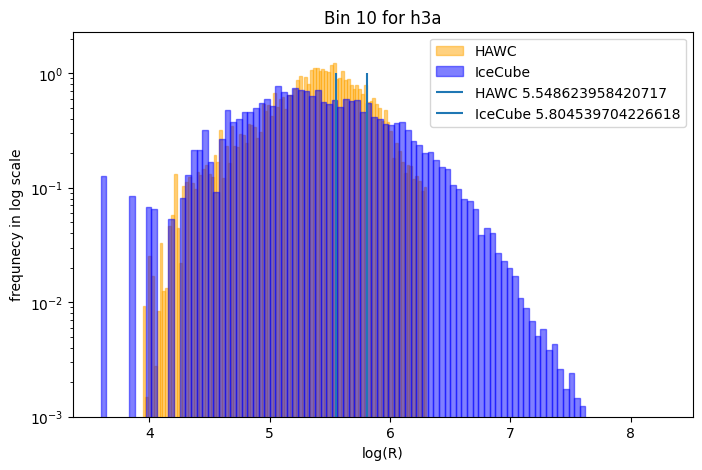

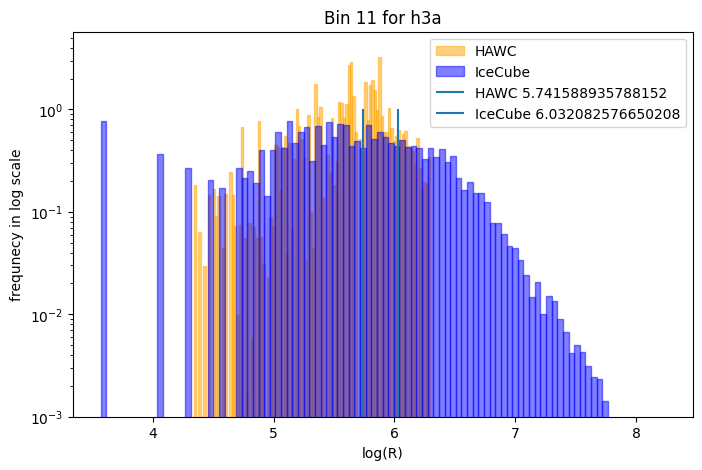

In [92]:
# h3a
for idx, (i, j, k, l) in enumerate(zip(cuts, icuts_h3a, log_mean_rig_h3a , np.log10(imean_rigs_h3a))):
    plt.figure(figsize = (8,5))
    plt.hist(np.log10(rigidity[i]), bins = 100, weights = h3a[i], label = 'HAWC', alpha = 0.5, edgecolor = 'orange', color = 'orange', density = True)
    plt.hist(np.log10(irigidity[j]), bins = 100, weights = weights_h3a[j], label = 'IceCube', alpha = 0.5, edgecolor = 'blue', color = 'blue', density = True)
    plt.vlines(k, ymin = 0, ymax = 1, label = f"HAWC {k}")
    plt.vlines(l, ymin = 0, ymax = 1, label = f"IceCube {l}")
    plt.semilogy()
    plt.ylim(bottom = 10**-3)
    plt.legend()
    plt.title(f"Bin {idx} for h3a")
    plt.xlabel('log(R)')
    plt.ylabel('frequnecy in log scale')
    plt.show()

# Systematic uncertainty

In [86]:
all_quantiles_gsf = []
all_quantiles_h3a = []
for cut in cuts:
    quantiles_gsf = weighted_quantile(rigidity[cut], [0.16, 0.5, 0.84], sample_weight = gsf[cut])
    quantiles_h3a = weighted_quantile(rigidity[cut], [0.16, 0.5, 0.84], sample_weight = h3a[cut])
    all_quantiles_gsf.append(quantiles_gsf)
    all_quantiles_h3a.append(quantiles_h3a)

all_quantiles_log_gsf = np.log10(all_quantiles_gsf)
all_quantiles_log_h3a = np.log10(all_quantiles_h3a)

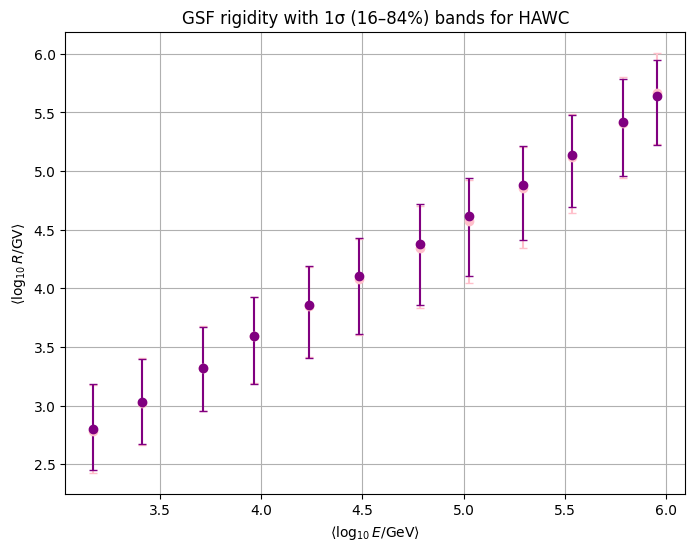

In [87]:
plt.figure(figsize=(8,6))
for xi, (q_lo_g, q_med_g, q_hi_g), (q_lo_h, q_med_h, q_hi_h) in zip(log_mean_e_gsf, all_quantiles_log_gsf, all_quantiles_log_h3a):
    lower_g = q_med_g - q_lo_g
    upper_g = q_hi_g  - q_med_g
    lower_h = q_med_h - q_lo_h
    upper_h = q_hi_h - q_med_h
    plt.errorbar(xi, q_med_g, yerr=[[lower_g],[upper_g]], fmt='o', capsize = 3, color = 'pink')
    plt.errorbar(xi, q_med_h, yerr=[[lower_h],[upper_h]], fmt='o', capsize = 3, color = 'purple')
plt.xlabel(r'$\langle\log_{10}E/\mathrm{GeV}\rangle$')
plt.ylabel(r'$\langle\log_{10}R/\mathrm{GV}\rangle$')
plt.title("GSF rigidity with 1σ (16–84%) bands for HAWC")
plt.grid(True)
plt.show()

In [88]:
iall_quantiles_gsf = []
iall_quantiles_h3a = []
for icut_g, icut_h in zip(icuts_gsf, icuts_h3a):
    iquantiles_gsf = weighted_quantile(irigidity[icut_g], [0.16, 0.5, 0.84], sample_weight = weights_gsf[icut_g])
    iquantiles_h3a = weighted_quantile(irigidity[icut_h], [0.16, 0.5, 0.84], sample_weight = weights_h3a[icut_h])
    iall_quantiles_gsf.append(iquantiles_gsf)
    iall_quantiles_h3a.append(iquantiles_h3a)

iall_quantiles_log_gsf = np.log10(iall_quantiles_gsf)
iall_quantiles_log_h3a = np.log10(iall_quantiles_h3a)

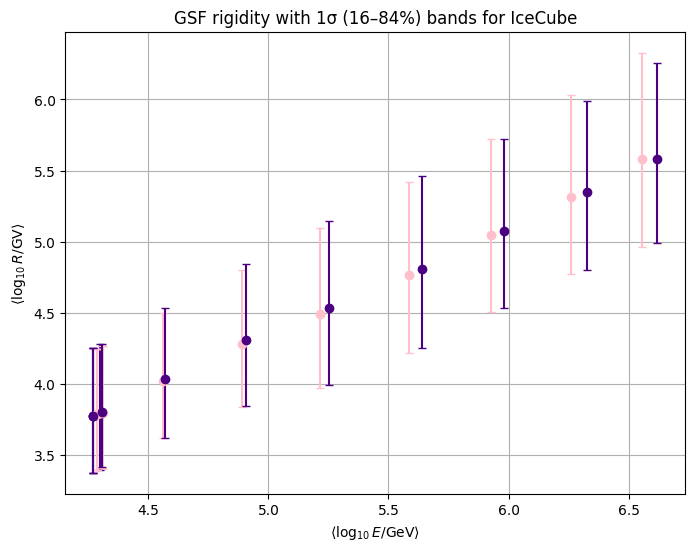

In [89]:
plt.figure(figsize=(8,6))
for xi_g, xi_h, (q_lo_g, q_med_g, q_hi_g), (q_lo_h, q_med_h, q_hi_h) in zip(np.log10(imean_energies_gsf), np.log10(imean_energies_h3a), iall_quantiles_log_gsf, iall_quantiles_log_h3a):
    lower_g = q_med_g - q_lo_g
    upper_g = q_hi_g  - q_med_g
    lower_h = q_med_h - q_lo_h
    upper_h = q_hi_h - q_med_h
    plt.errorbar(xi_g, q_med_g, yerr=[[lower_g],[upper_g]], fmt='o', capsize = 3, color = 'pink')
    plt.errorbar(xi_h, q_med_h, yerr=[[lower_h],[upper_h]], fmt='o', capsize = 3, color = 'indigo')
plt.xlabel(r'$\langle\log_{10}E/\mathrm{GeV}\rangle$')
plt.ylabel(r'$\langle\log_{10}R/\mathrm{GV}\rangle$')
plt.title("GSF rigidity with 1σ (16–84%) bands for IceCube")
plt.grid(True)
plt.show()